In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,4
1098201,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,4
1098202,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,4
1098203,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,4


<Axes: xlabel='activity', ylabel='count'>

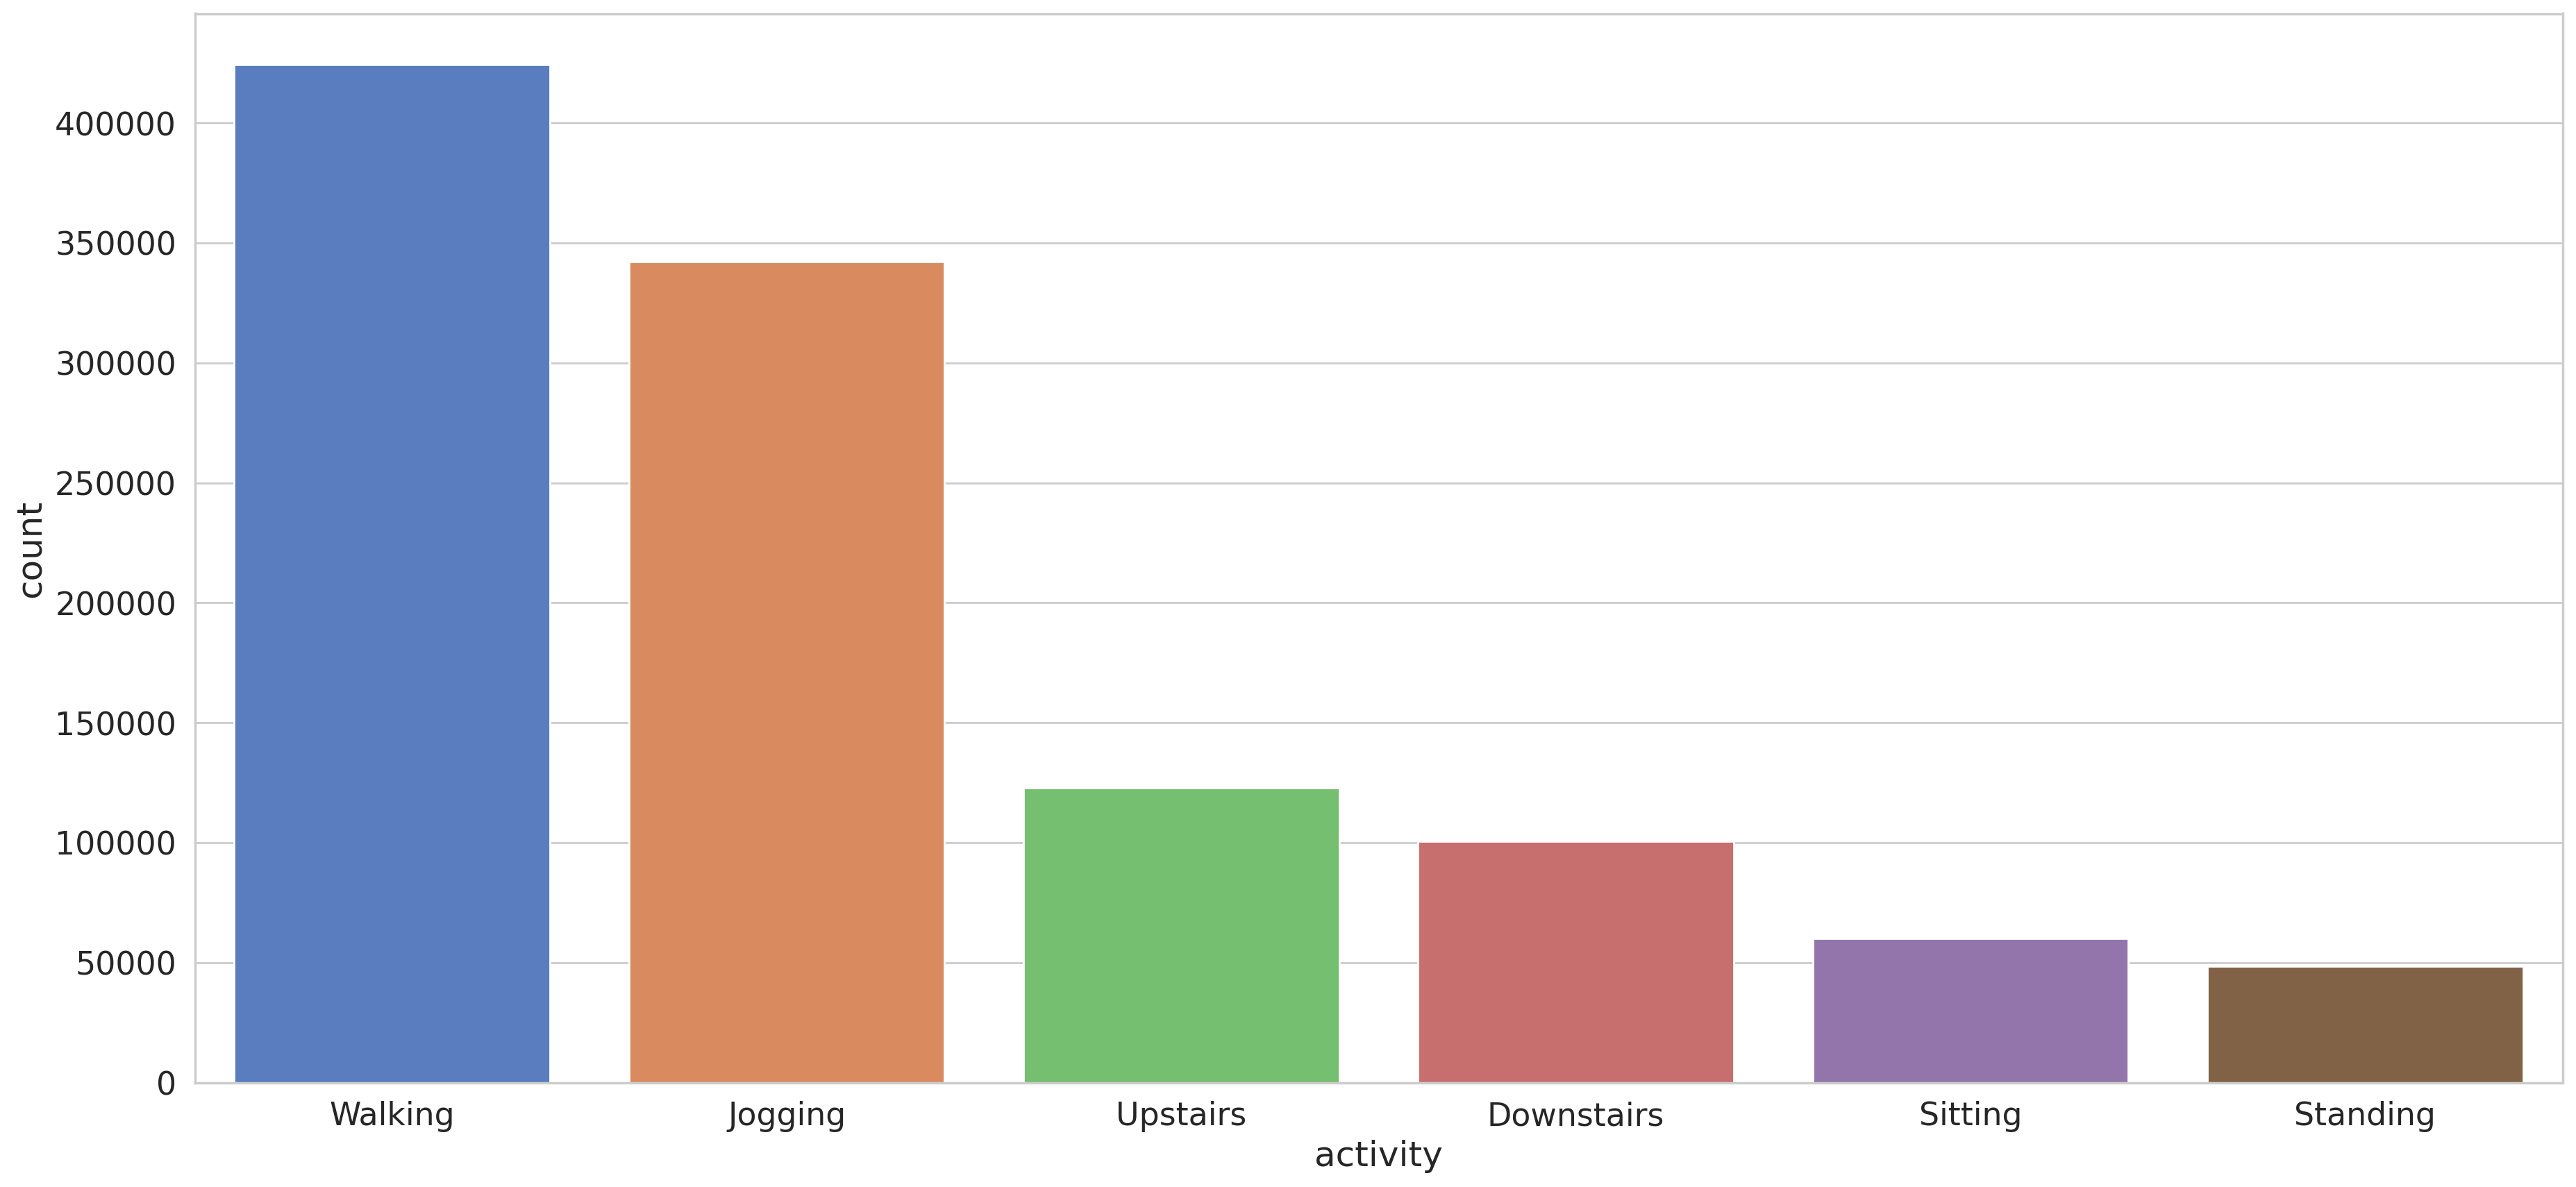

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

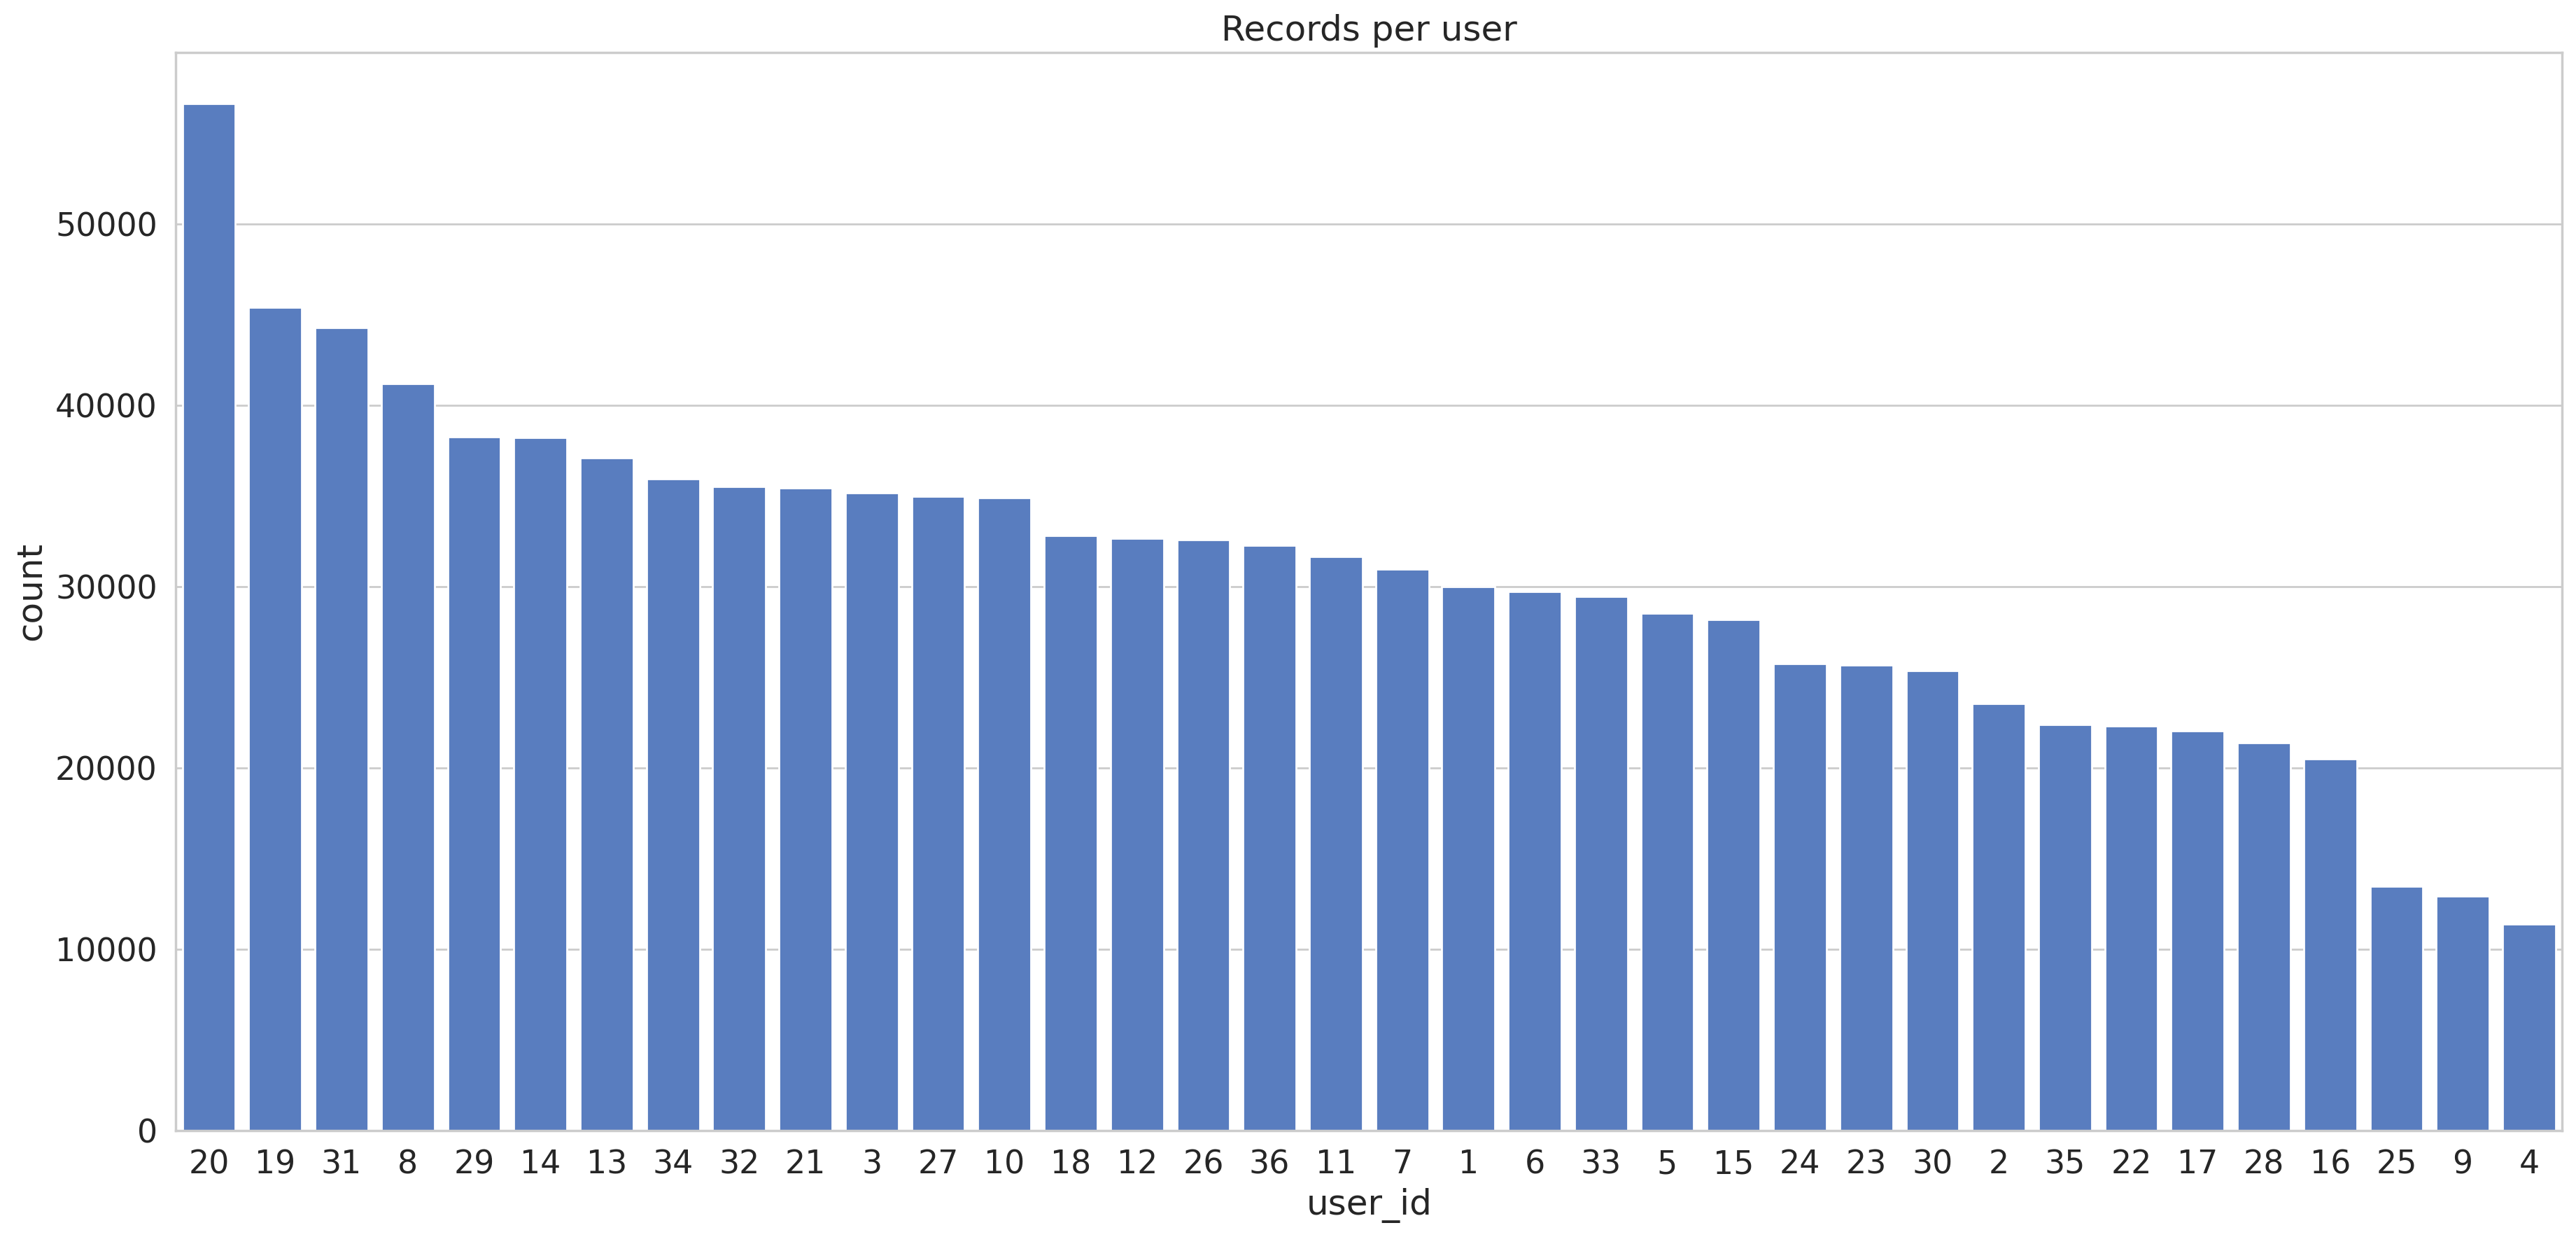

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


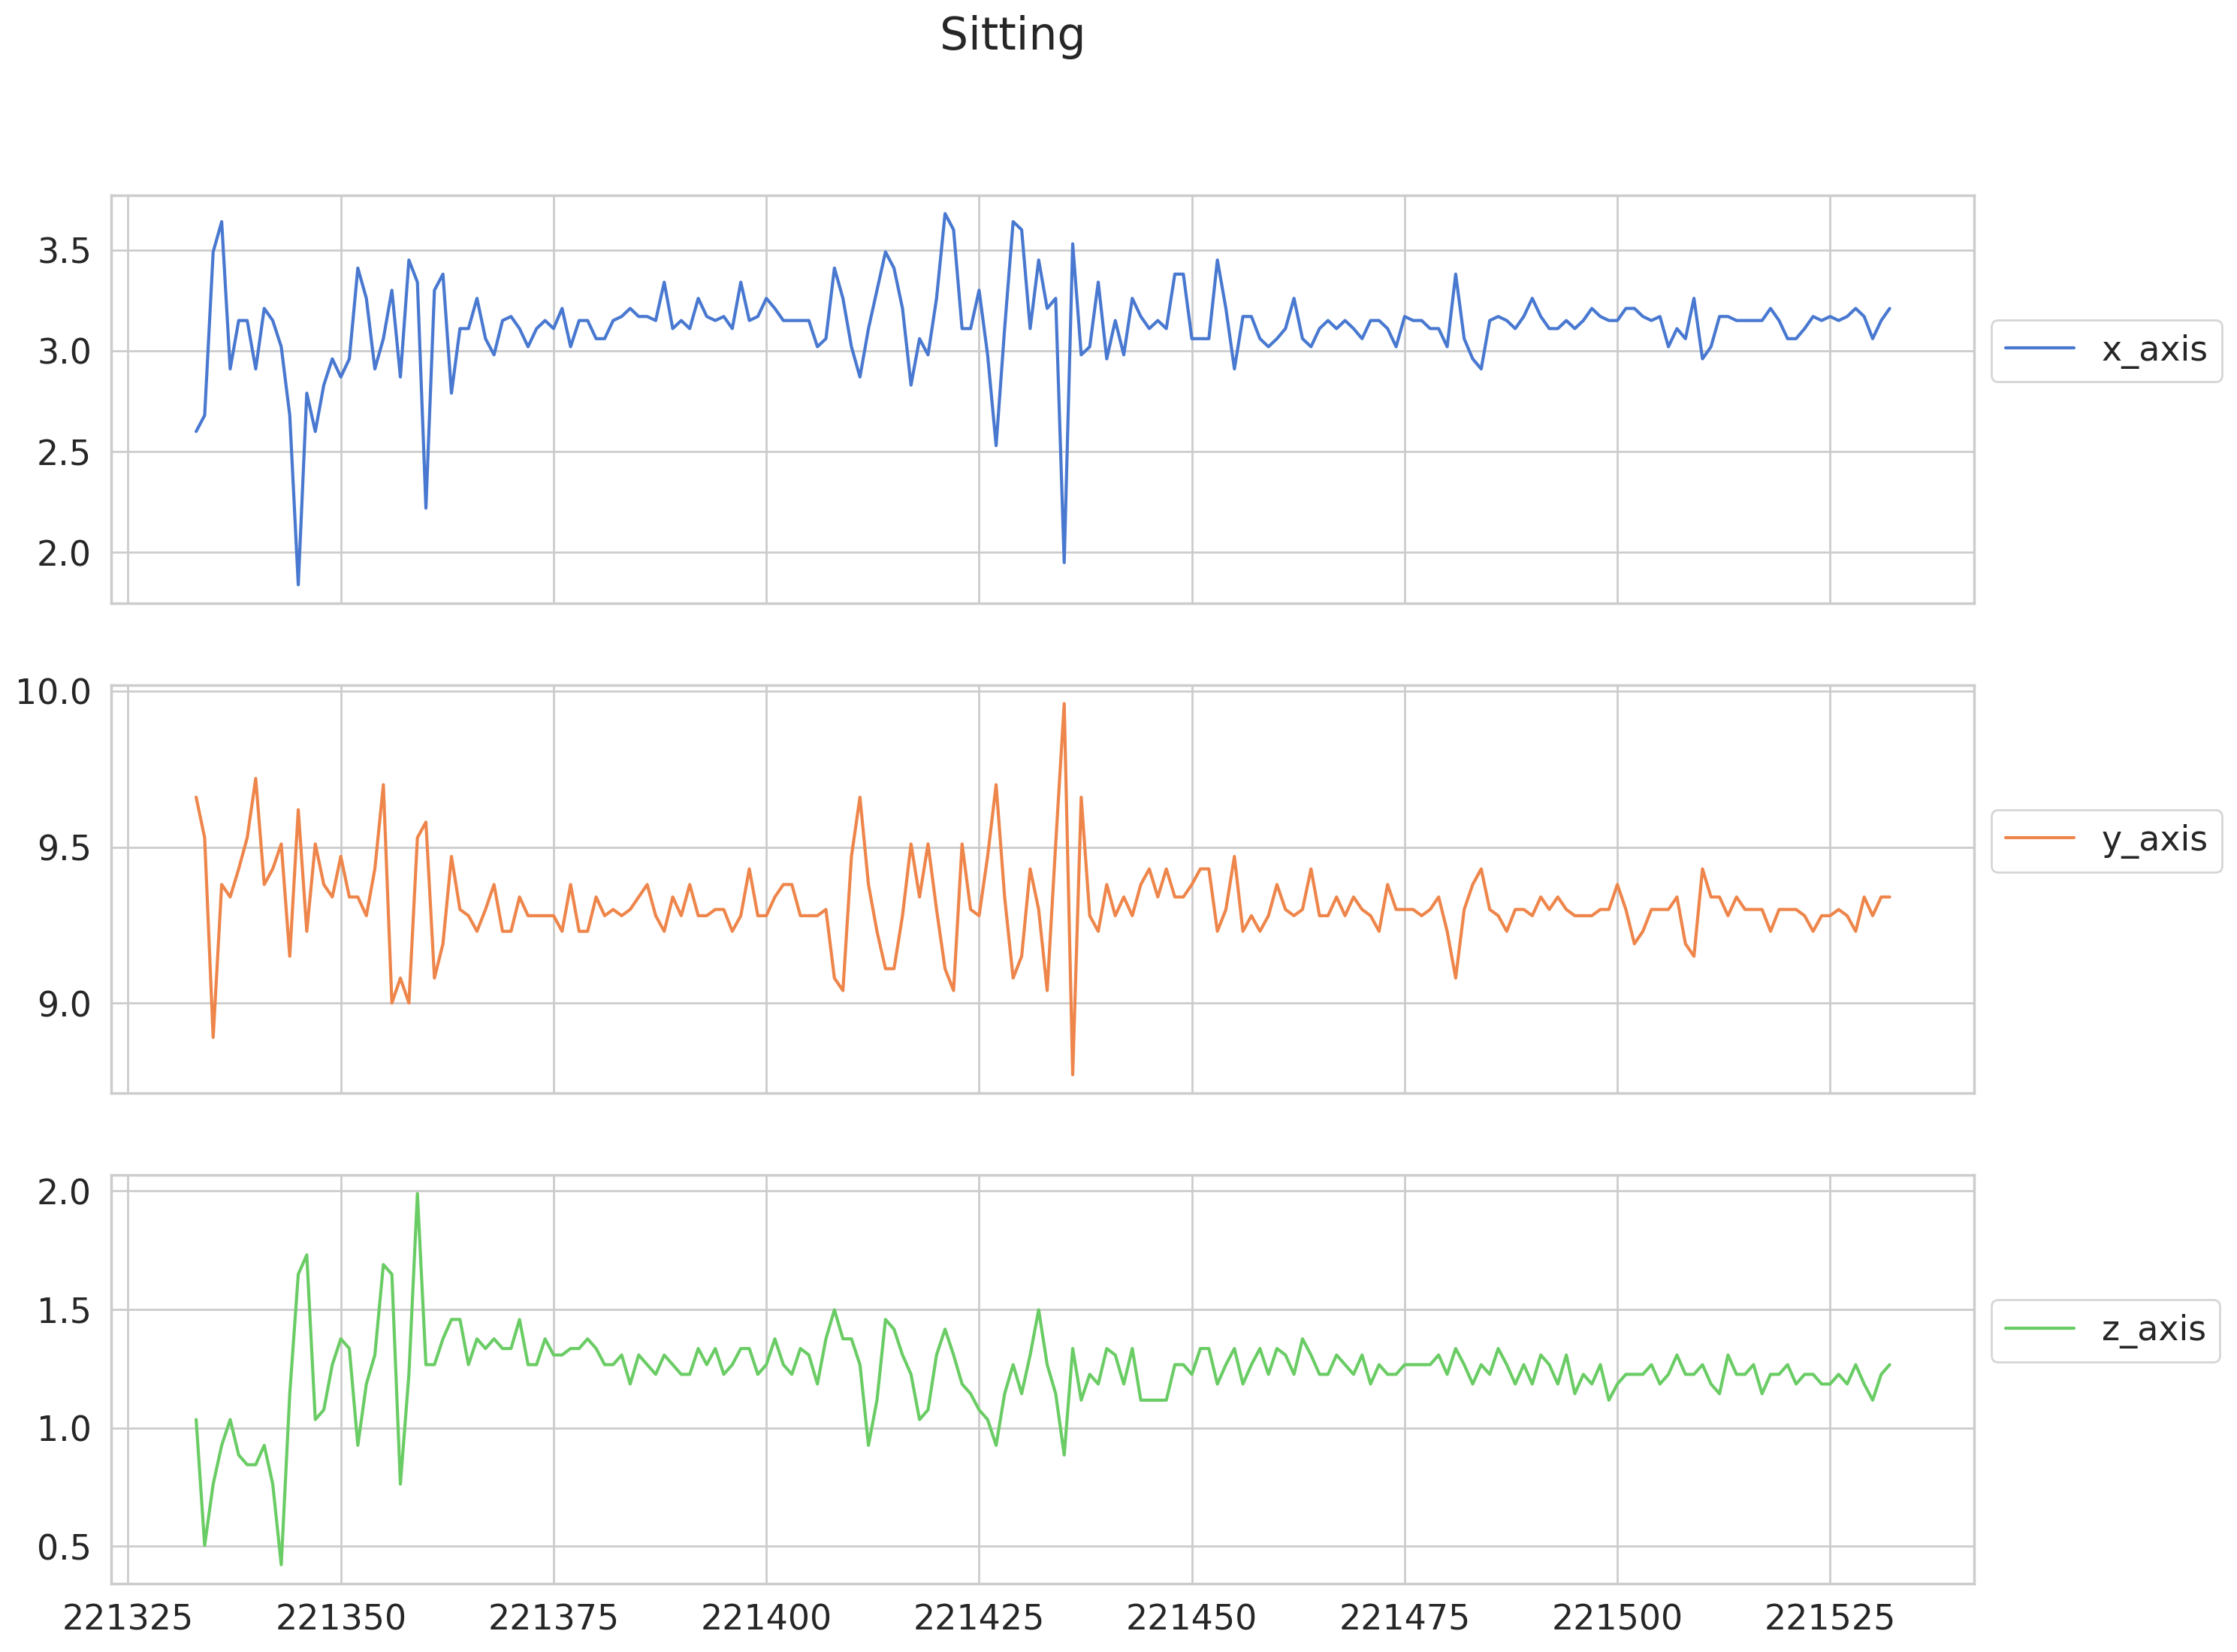

In [8]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [9]:
indexes = df[ (df['activity'] != 'Sitting') & (df['activity'] != 'Standing')].index
df.drop(indexes , inplace=True)


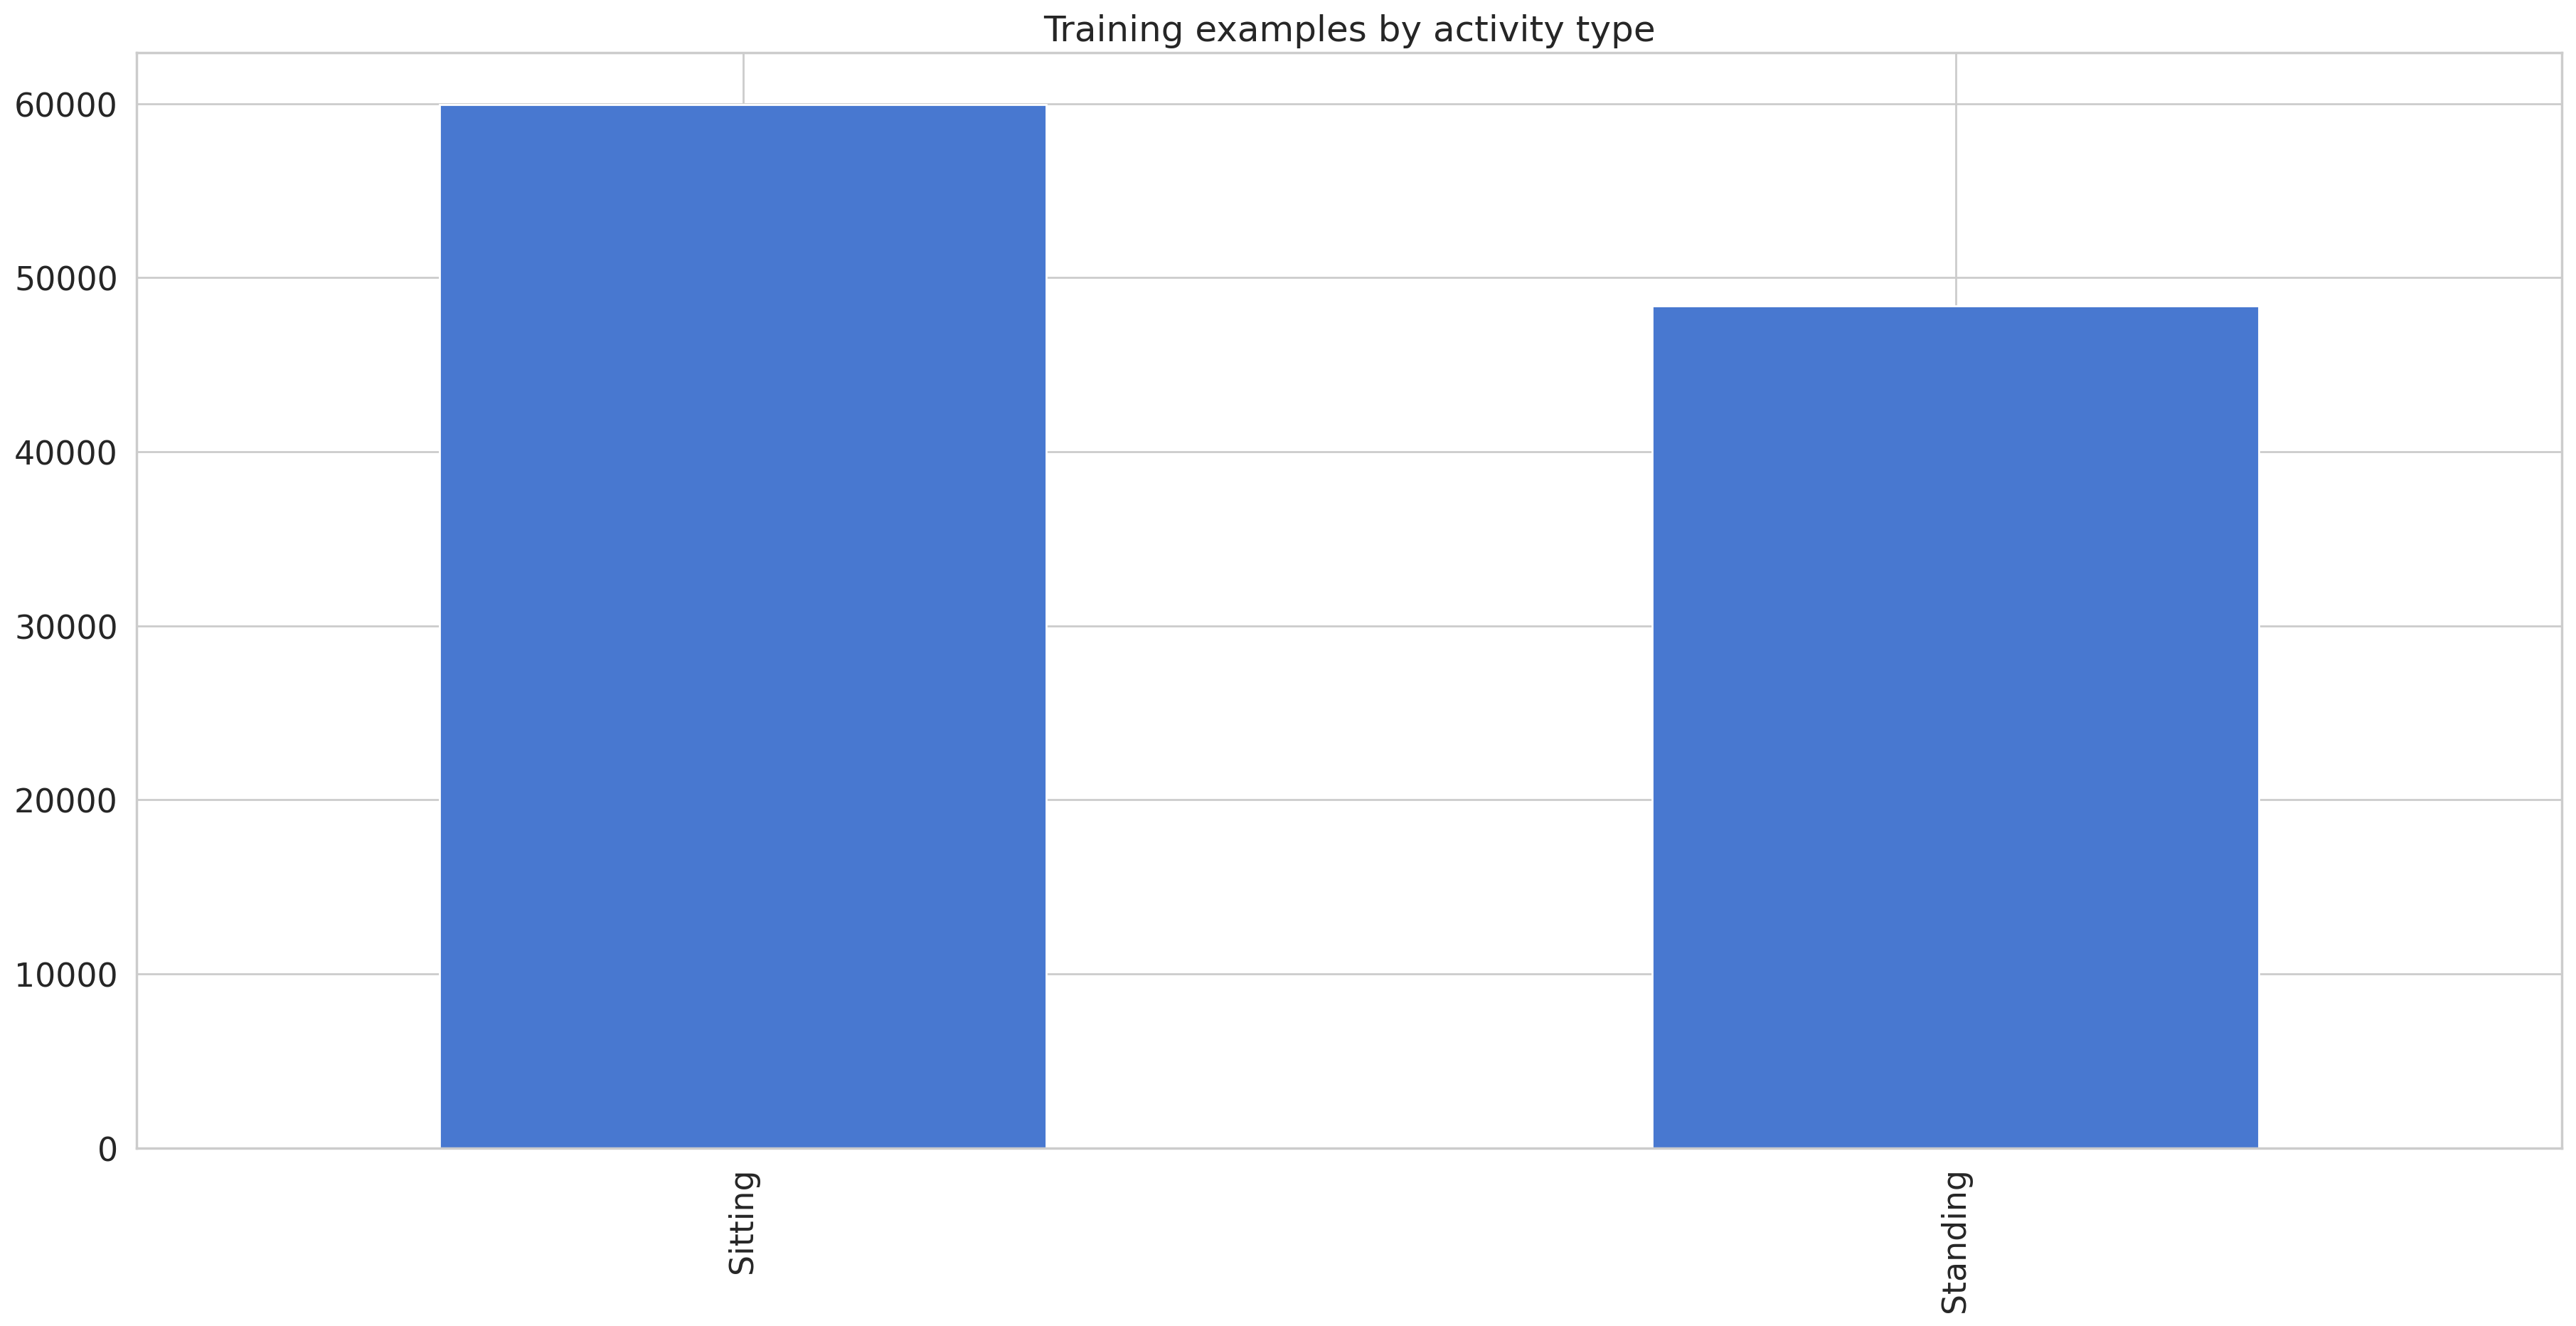

In [10]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

random_seed = 42

n_time_steps = 50

n_features = 3

step = 10

n_classes = 6

n_epochs = 50       

batch_size = 1024   

learning_rate = 0.0025

l2_loss = 0.0015


In [11]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
221333,27,Sitting,12363992261000,0.490260,0.617689,-0.241746,4
221334,27,Sitting,12364042279000,0.503247,0.599144,-0.311732,4
221335,27,Sitting,12364092267000,0.634740,0.507846,-0.277636,4
221336,27,Sitting,12364142316000,0.659091,0.577746,-0.256102,4
221337,27,Sitting,12364192273000,0.540584,0.572040,-0.241746,4
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,1.529221,-0.984308,-0.155468,4
1098201,19,Sitting,131623371431000,1.535714,-0.968616,-0.150198,4
1098202,19,Sitting,131623411592000,1.542208,-0.957204,-0.155468,4
1098203,19,Sitting,131623491487000,1.529221,-0.968616,-0.150198,4


In [12]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 50
STEP = 10

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)

X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6930, 50, 3) (6930, 1)
(2166, 50, 3) (2166, 1)


In [13]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(6930, 50, 3) (6930, 2) (2166, 50, 3) (2166, 2)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:

batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015
n_timesteps,n_features,n_outputs= X_train.shape[1],X_train.shape[2],y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(50, 3, 2)

# LSTM1 - CNN1


In [15]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           67584     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 conv1d (Conv1D)             (None, 48, 64)            24640     
                                                                 
 dropout_1 (Dropout)         (None, 48, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 24, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                        

In [16]:
# validation_split = 0.1
batch_size = 1024

train_epochs = 10

history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
7/7 [==============================] - 11s 271ms/step - loss: 0.2744 - accuracy: 0.9084 - val_loss: 0.1232 - val_accuracy: 0.9515
Epoch 2/10
7/7 [==============================] - 0s 39ms/step - loss: 0.1246 - accuracy: 0.9544 - val_loss: 0.1104 - val_accuracy: 0.9625
Epoch 3/10
7/7 [==============================] - 0s 42ms/step - loss: 0.1045 - accuracy: 0.9644 - val_loss: 0.1268 - val_accuracy: 0.9735
Epoch 4/10
7/7 [==============================] - 0s 33ms/step - loss: 0.0956 - accuracy: 0.9701 - val_loss: 0.0989 - val_accuracy: 0.9735
Epoch 5/10
7/7 [==============================] - 0s 41ms/step - loss: 0.0894 - accuracy: 0.9691 - val_loss: 0.1017 - val_accuracy: 0.9740
Epoch 6/10
7/7 [==============================] - 0s 41ms/step - loss: 0.0825 - accuracy: 0.9723 - val_loss: 0.1007 - val_accuracy: 0.9735
Epoch 7/10
7/7 [==============================] - 0s 29ms/step - loss: 0.0787 - accuracy: 0.9736 - val_loss: 0.0909 - val_accuracy: 0.9729
Epoch 8/10
7/7 [=========

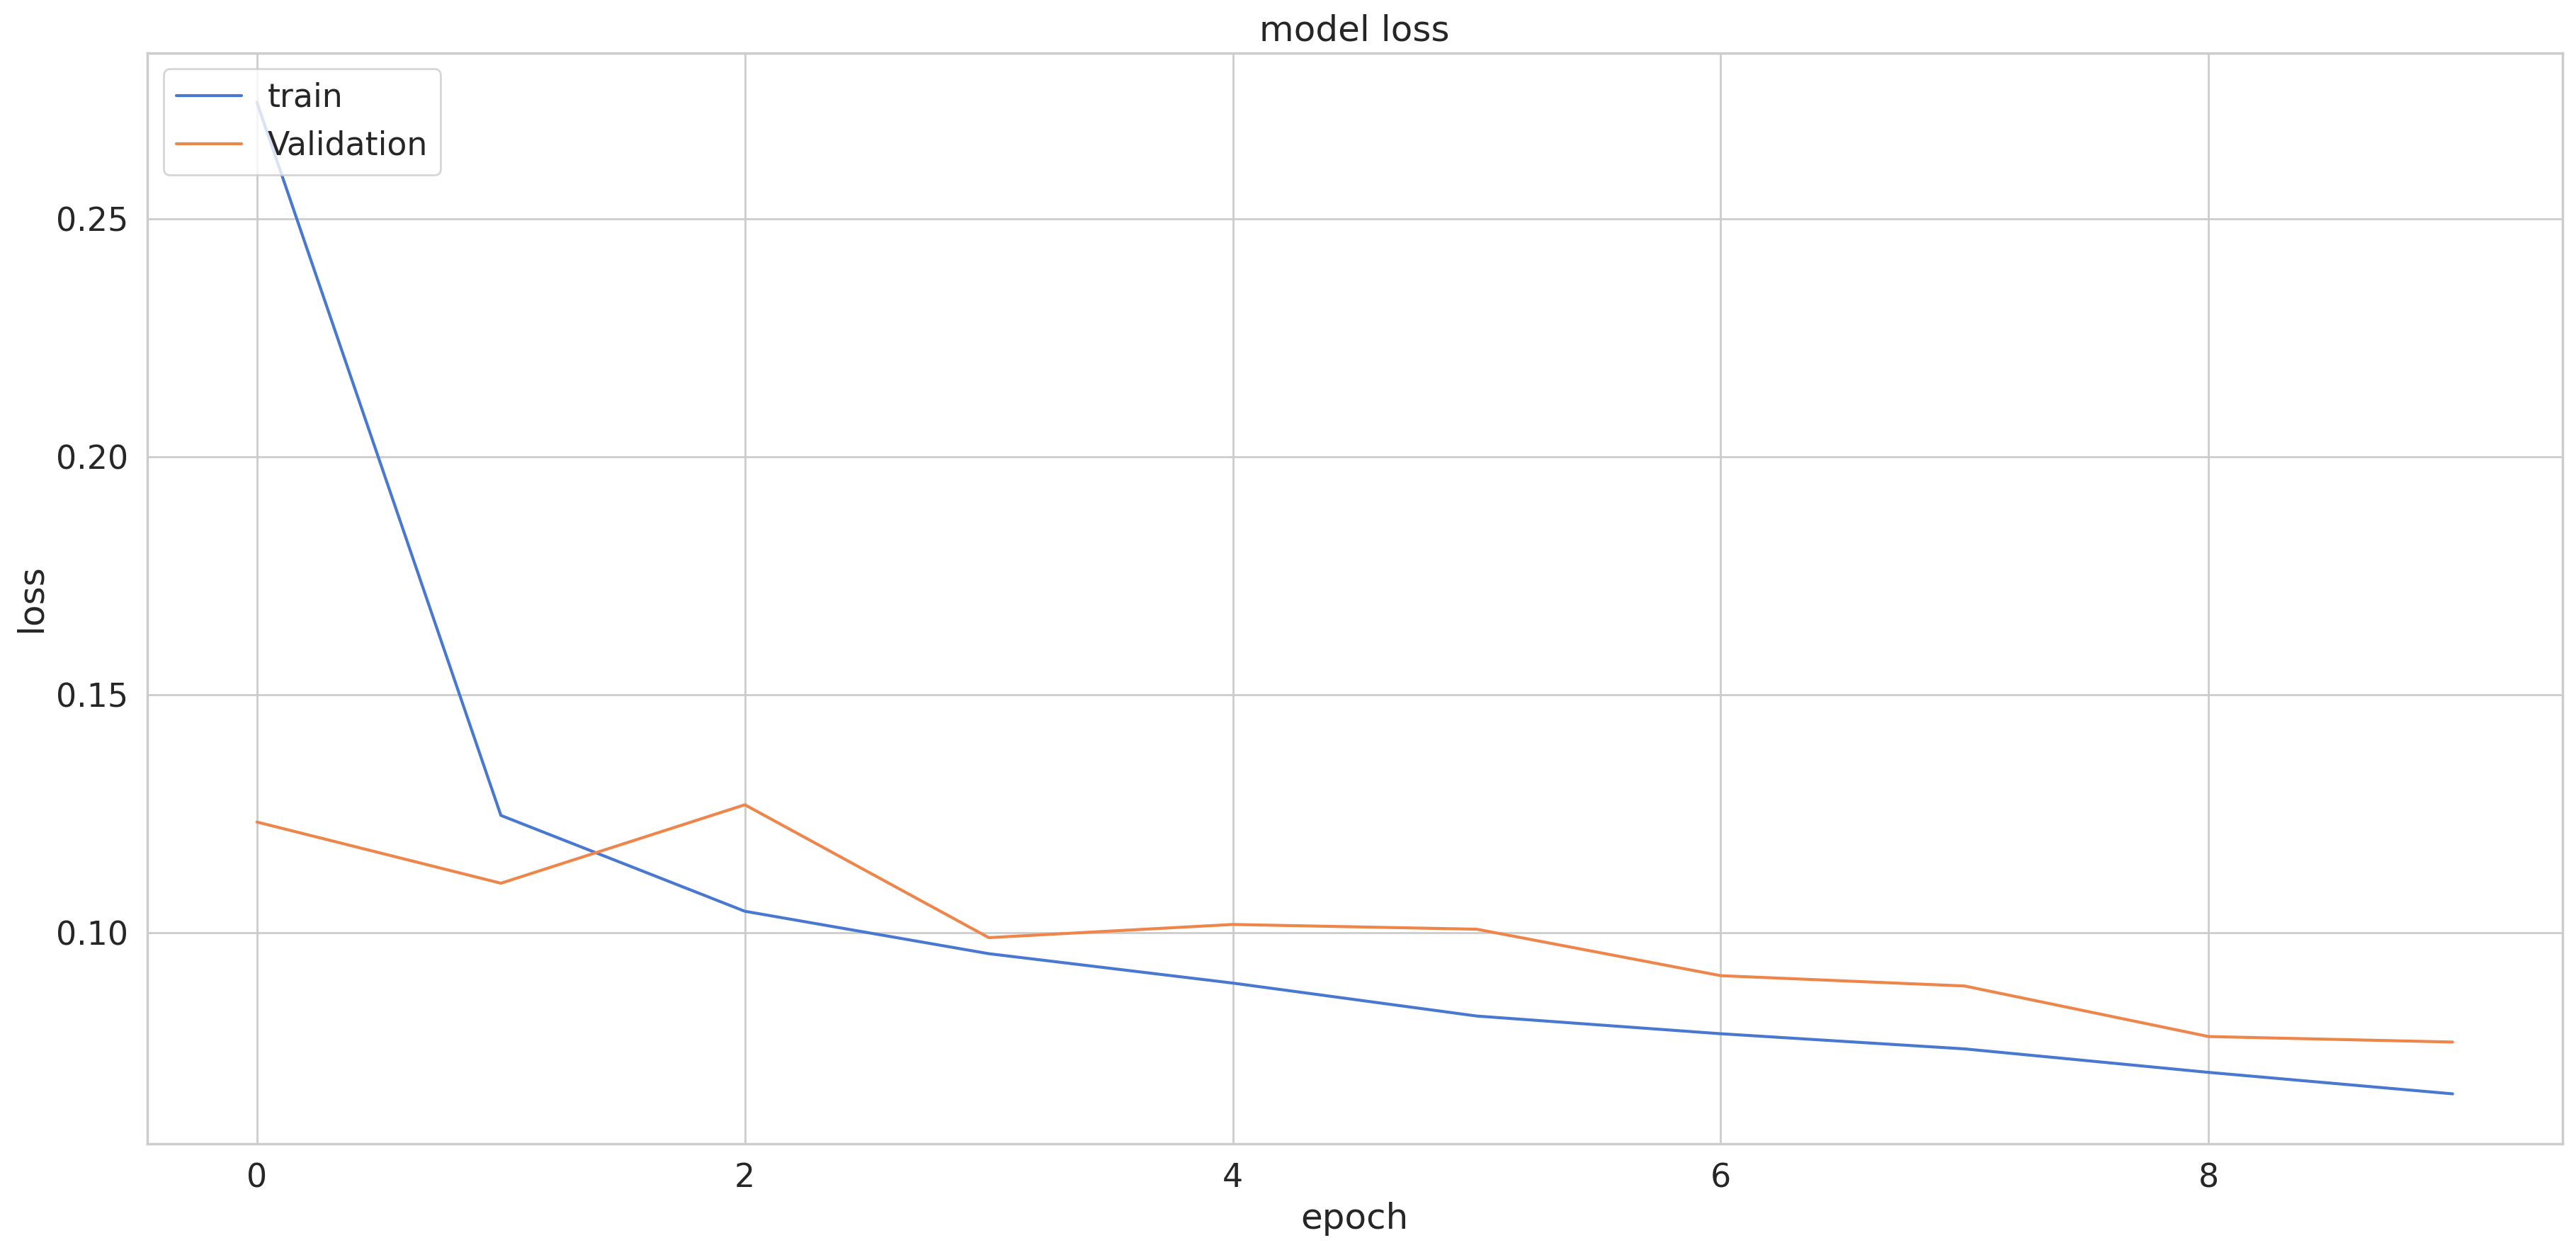

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

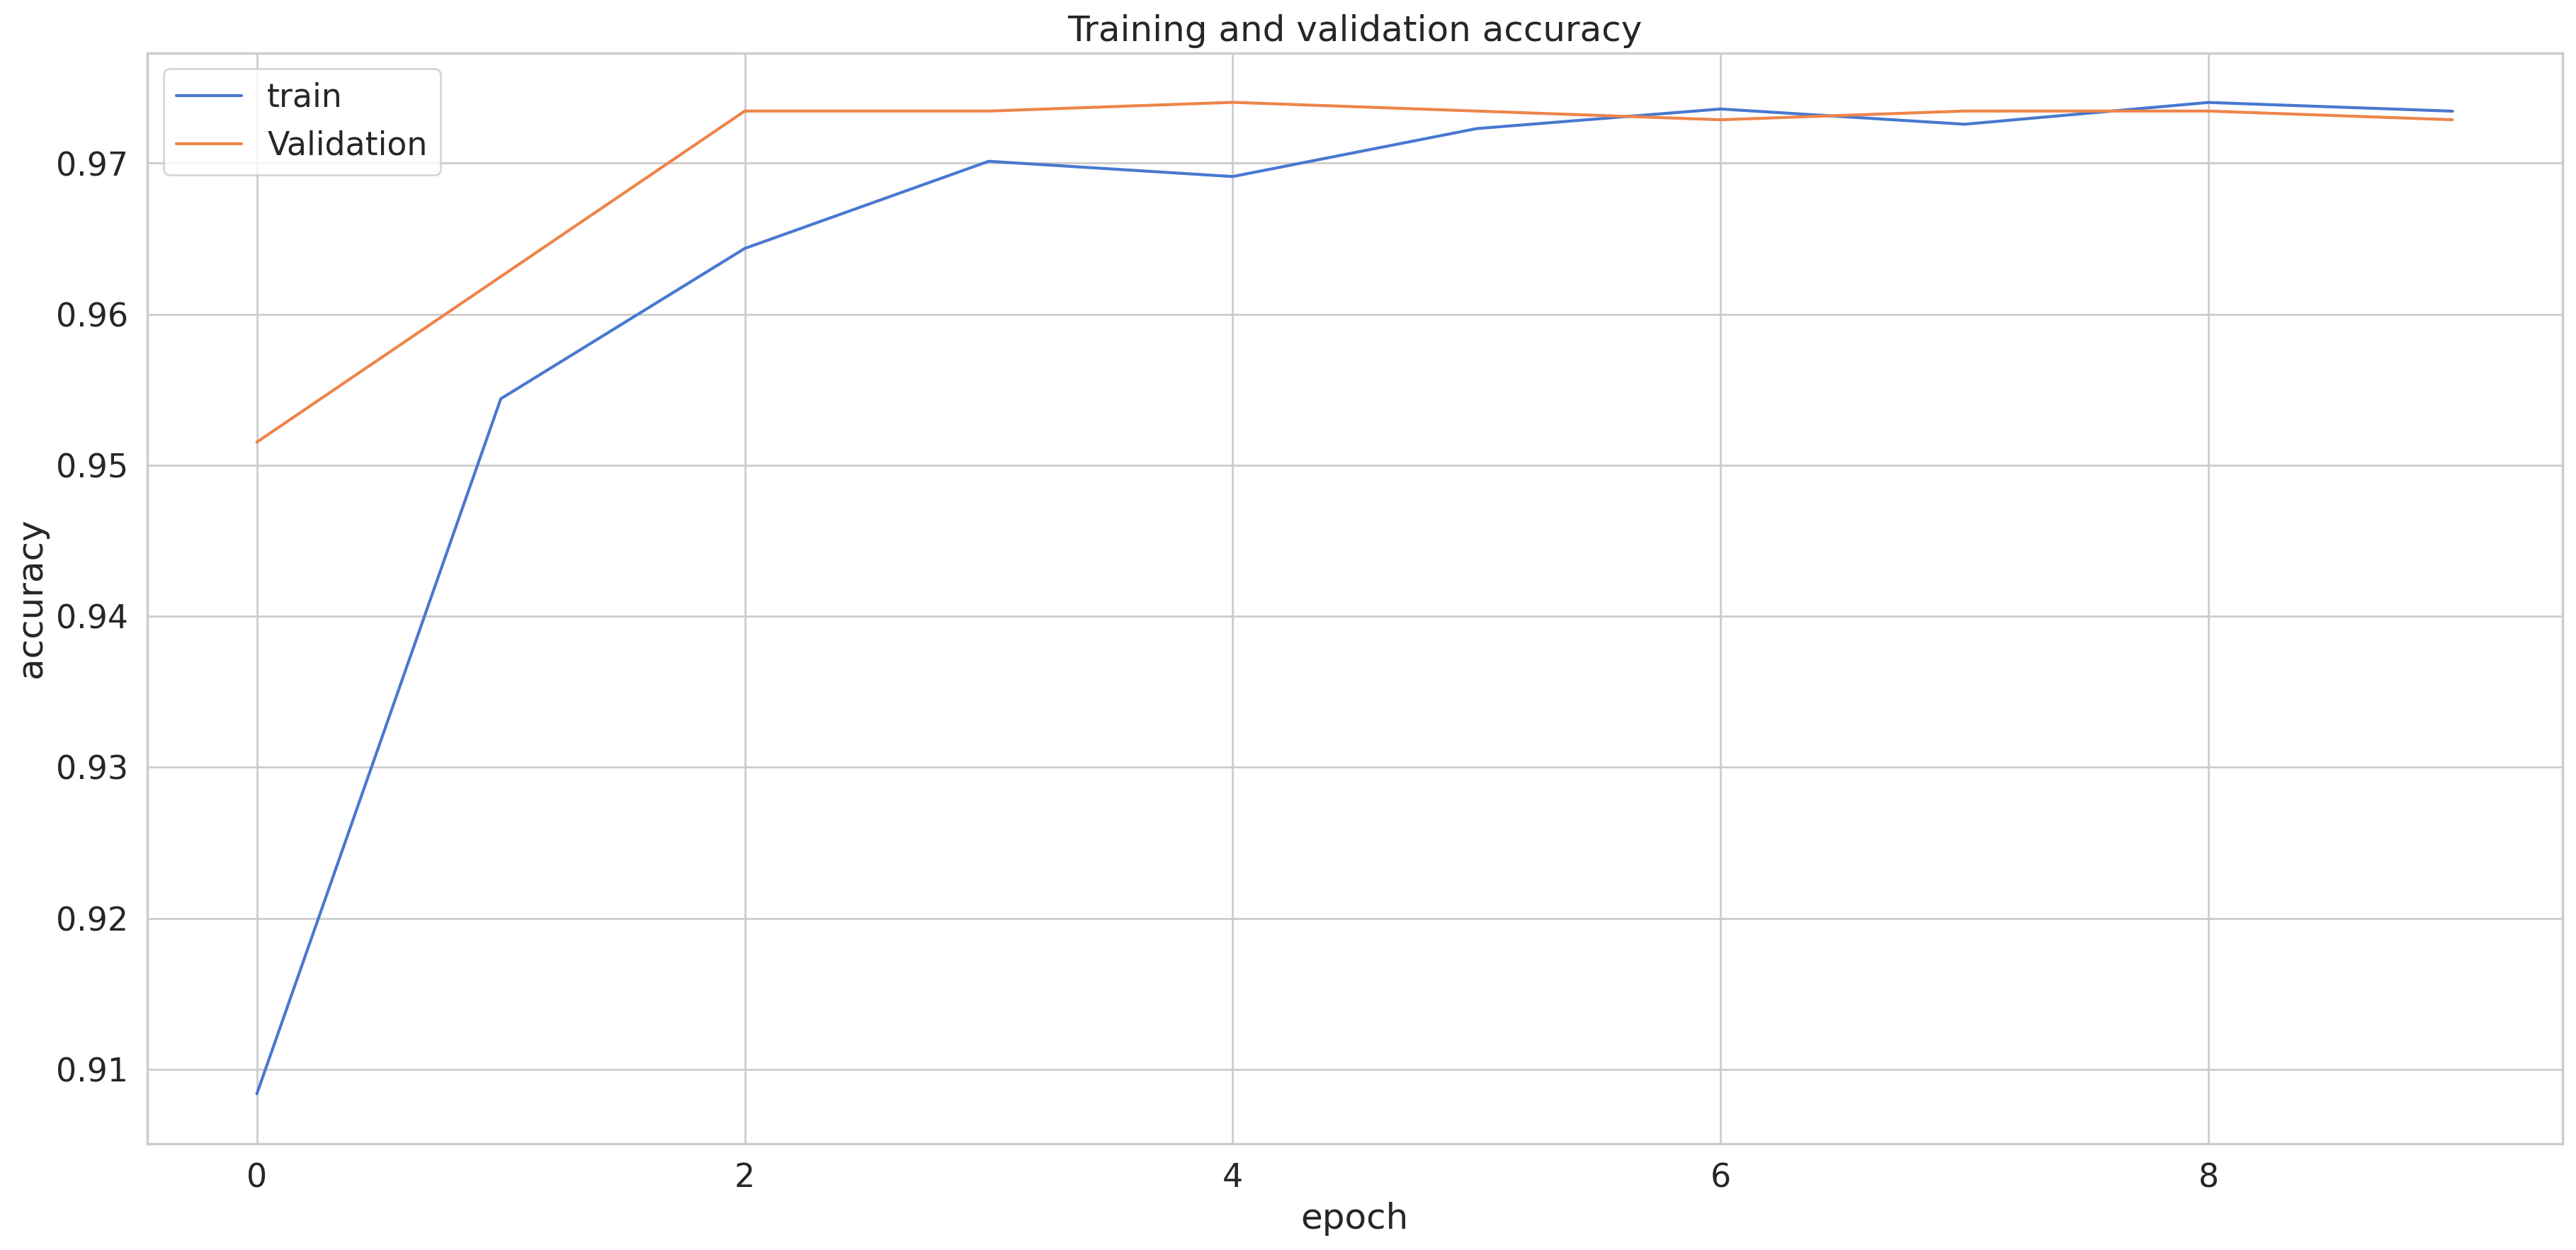

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 1s 3ms/step
f1_score =  0.9755794159387752
0.9755309325946445
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1199
           1       0.95      1.00      0.97       967

    accuracy                           0.98      2166
   macro avg       0.97      0.98      0.98      2166
weighted avg       0.98      0.98      0.98      2166



<Axes: >

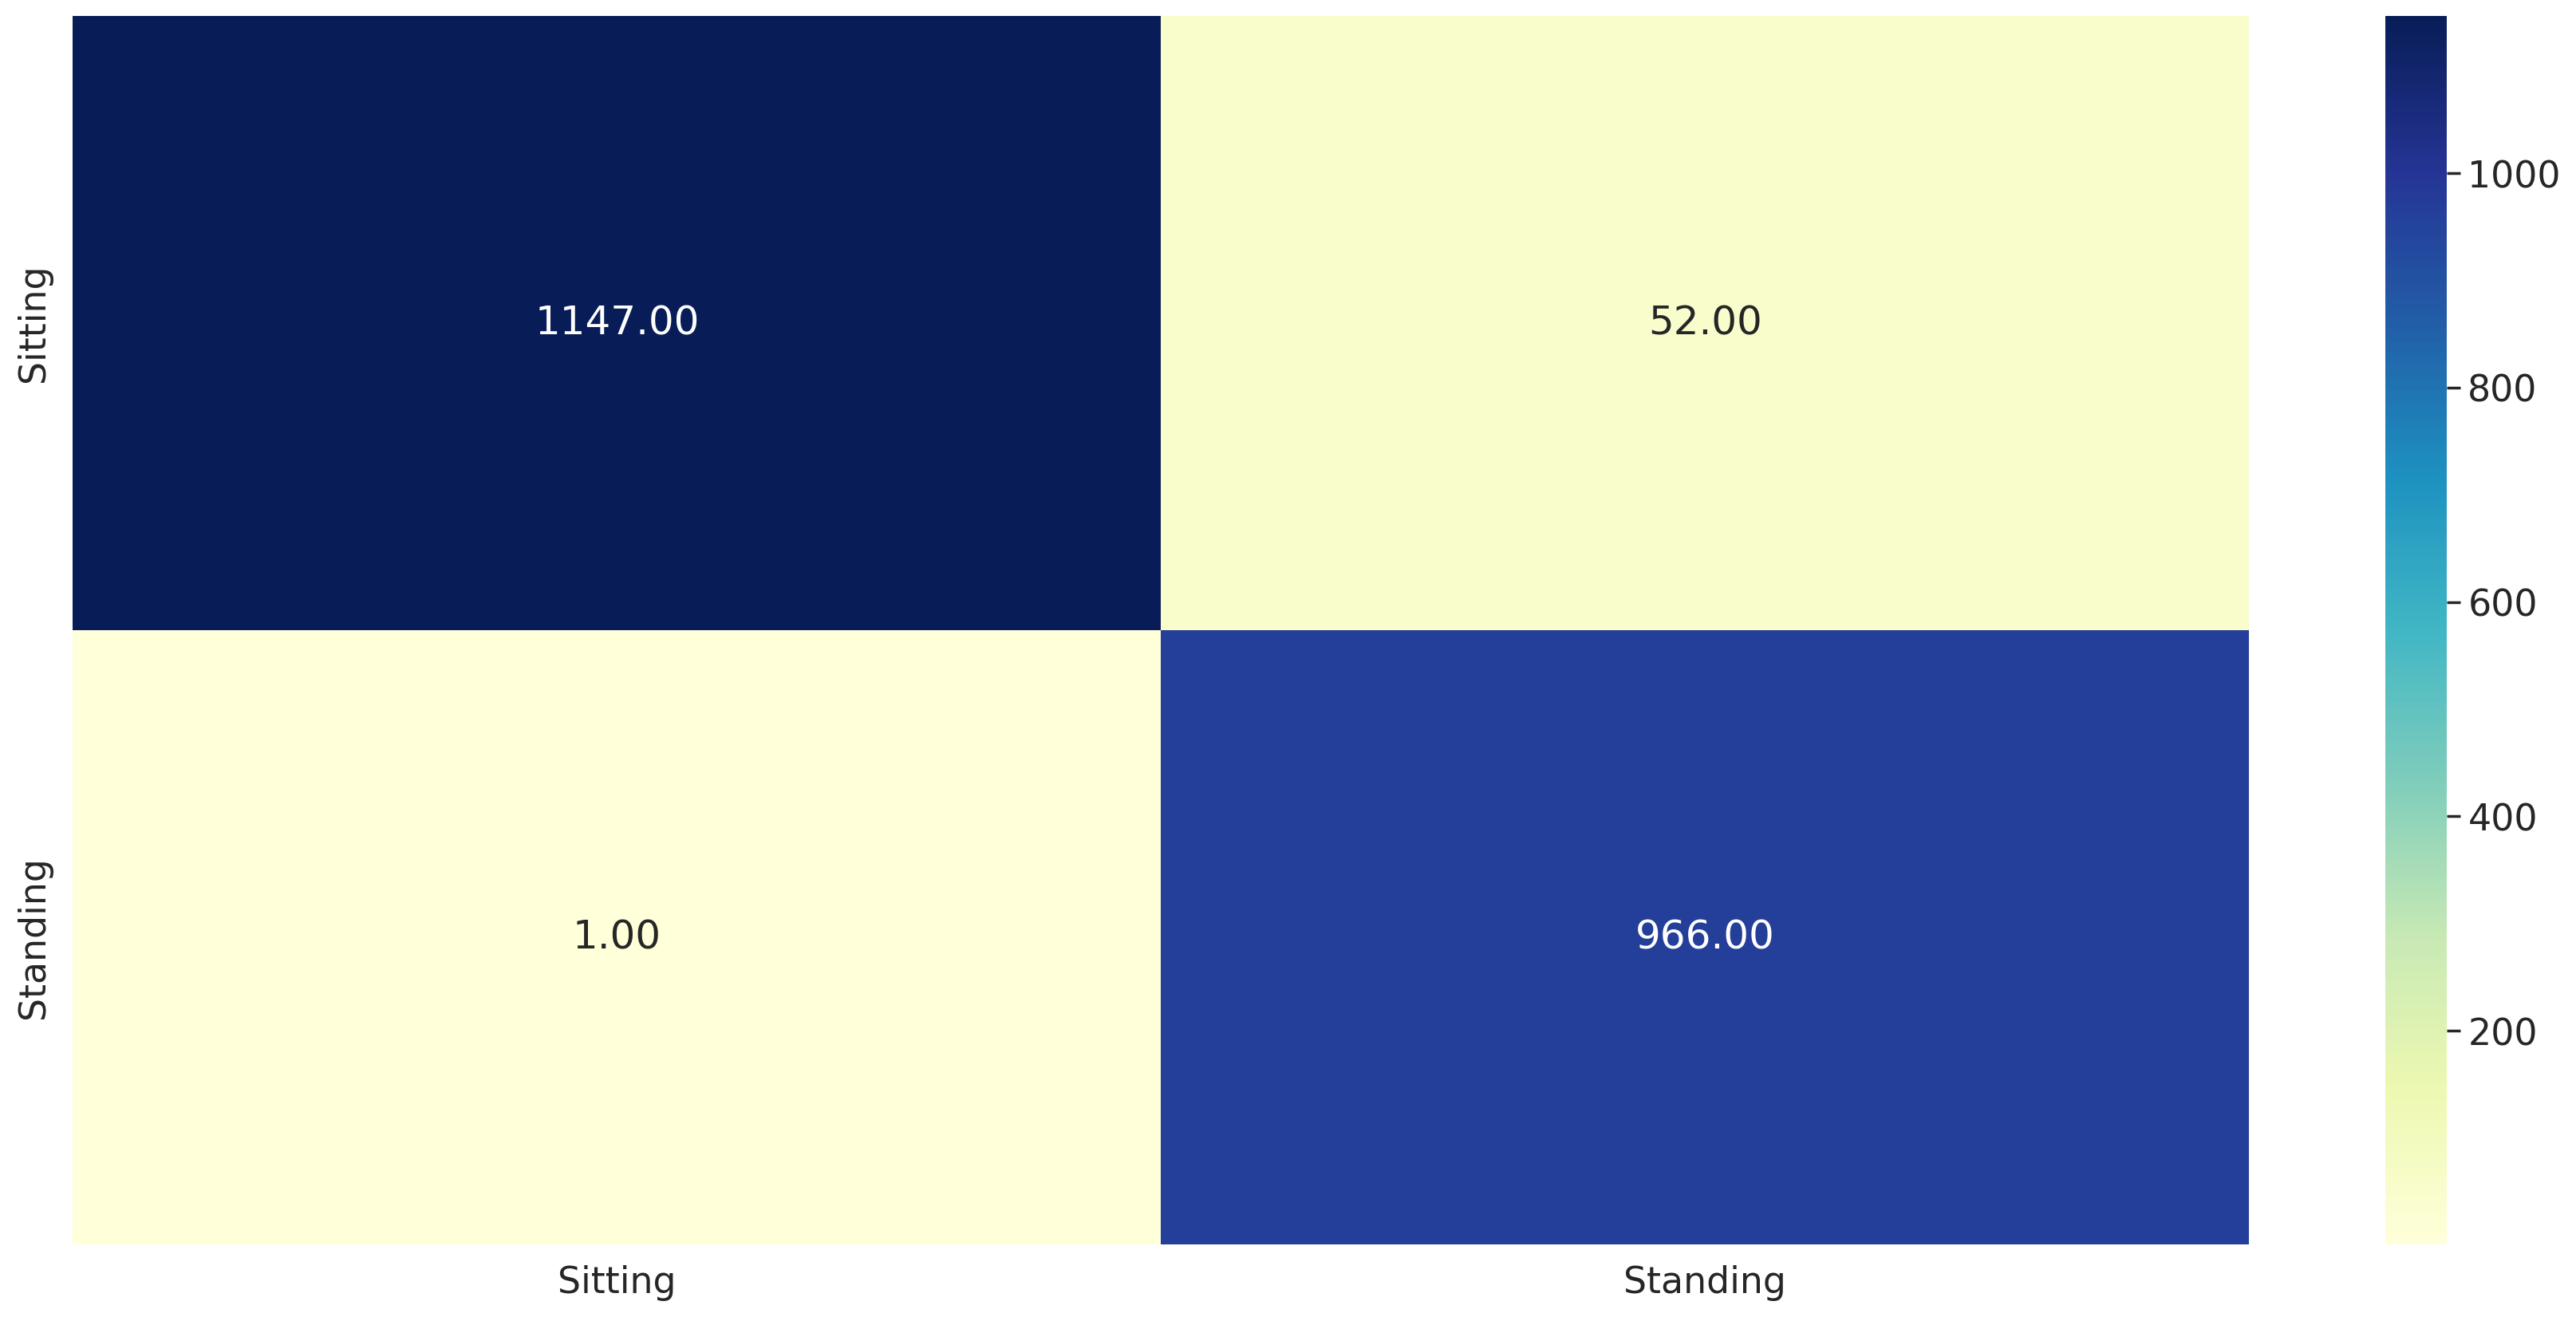

In [19]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM1 - CNN2

In [20]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50, 128)           67584     
                                                                 
 dropout_2 (Dropout)         (None, 50, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 48, 64)            24640     
                                                                 
 conv1d_2 (Conv1D)           (None, 46, 64)            12352     
                                                                 
 dropout_3 (Dropout)         (None, 46, 64)            0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 23, 64)            0         
 g1D)                                                            
                                                      

In [21]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 8s 49ms/step - loss: 0.1361 - accuracy: 0.9518 - val_loss: 0.1195 - val_accuracy: 0.9735
Epoch 2/10
55/55 [==============================] - 1s 10ms/step - loss: 0.0743 - accuracy: 0.9726 - val_loss: 0.0787 - val_accuracy: 0.9740
Epoch 3/10
55/55 [==============================] - 0s 8ms/step - loss: 0.0619 - accuracy: 0.9765 - val_loss: 0.0669 - val_accuracy: 0.9919
Epoch 4/10
55/55 [==============================] - 0s 8ms/step - loss: 0.0658 - accuracy: 0.9851 - val_loss: 0.0933 - val_accuracy: 0.9908
Epoch 5/10
55/55 [==============================] - 0s 8ms/step - loss: 0.0435 - accuracy: 0.9928 - val_loss: 0.0596 - val_accuracy: 0.9925
Epoch 6/10
55/55 [==============================] - 0s 8ms/step - loss: 0.0349 - accuracy: 0.9929 - val_loss: 0.0490 - val_accuracy: 0.9913
Epoch 7/10
55/55 [==============================] - 0s 8ms/step - loss: 0.0337 - accuracy: 0.9918 - val_loss: 0.0478 - val_accuracy: 0.9919
Epoch 8/10
55/55 [

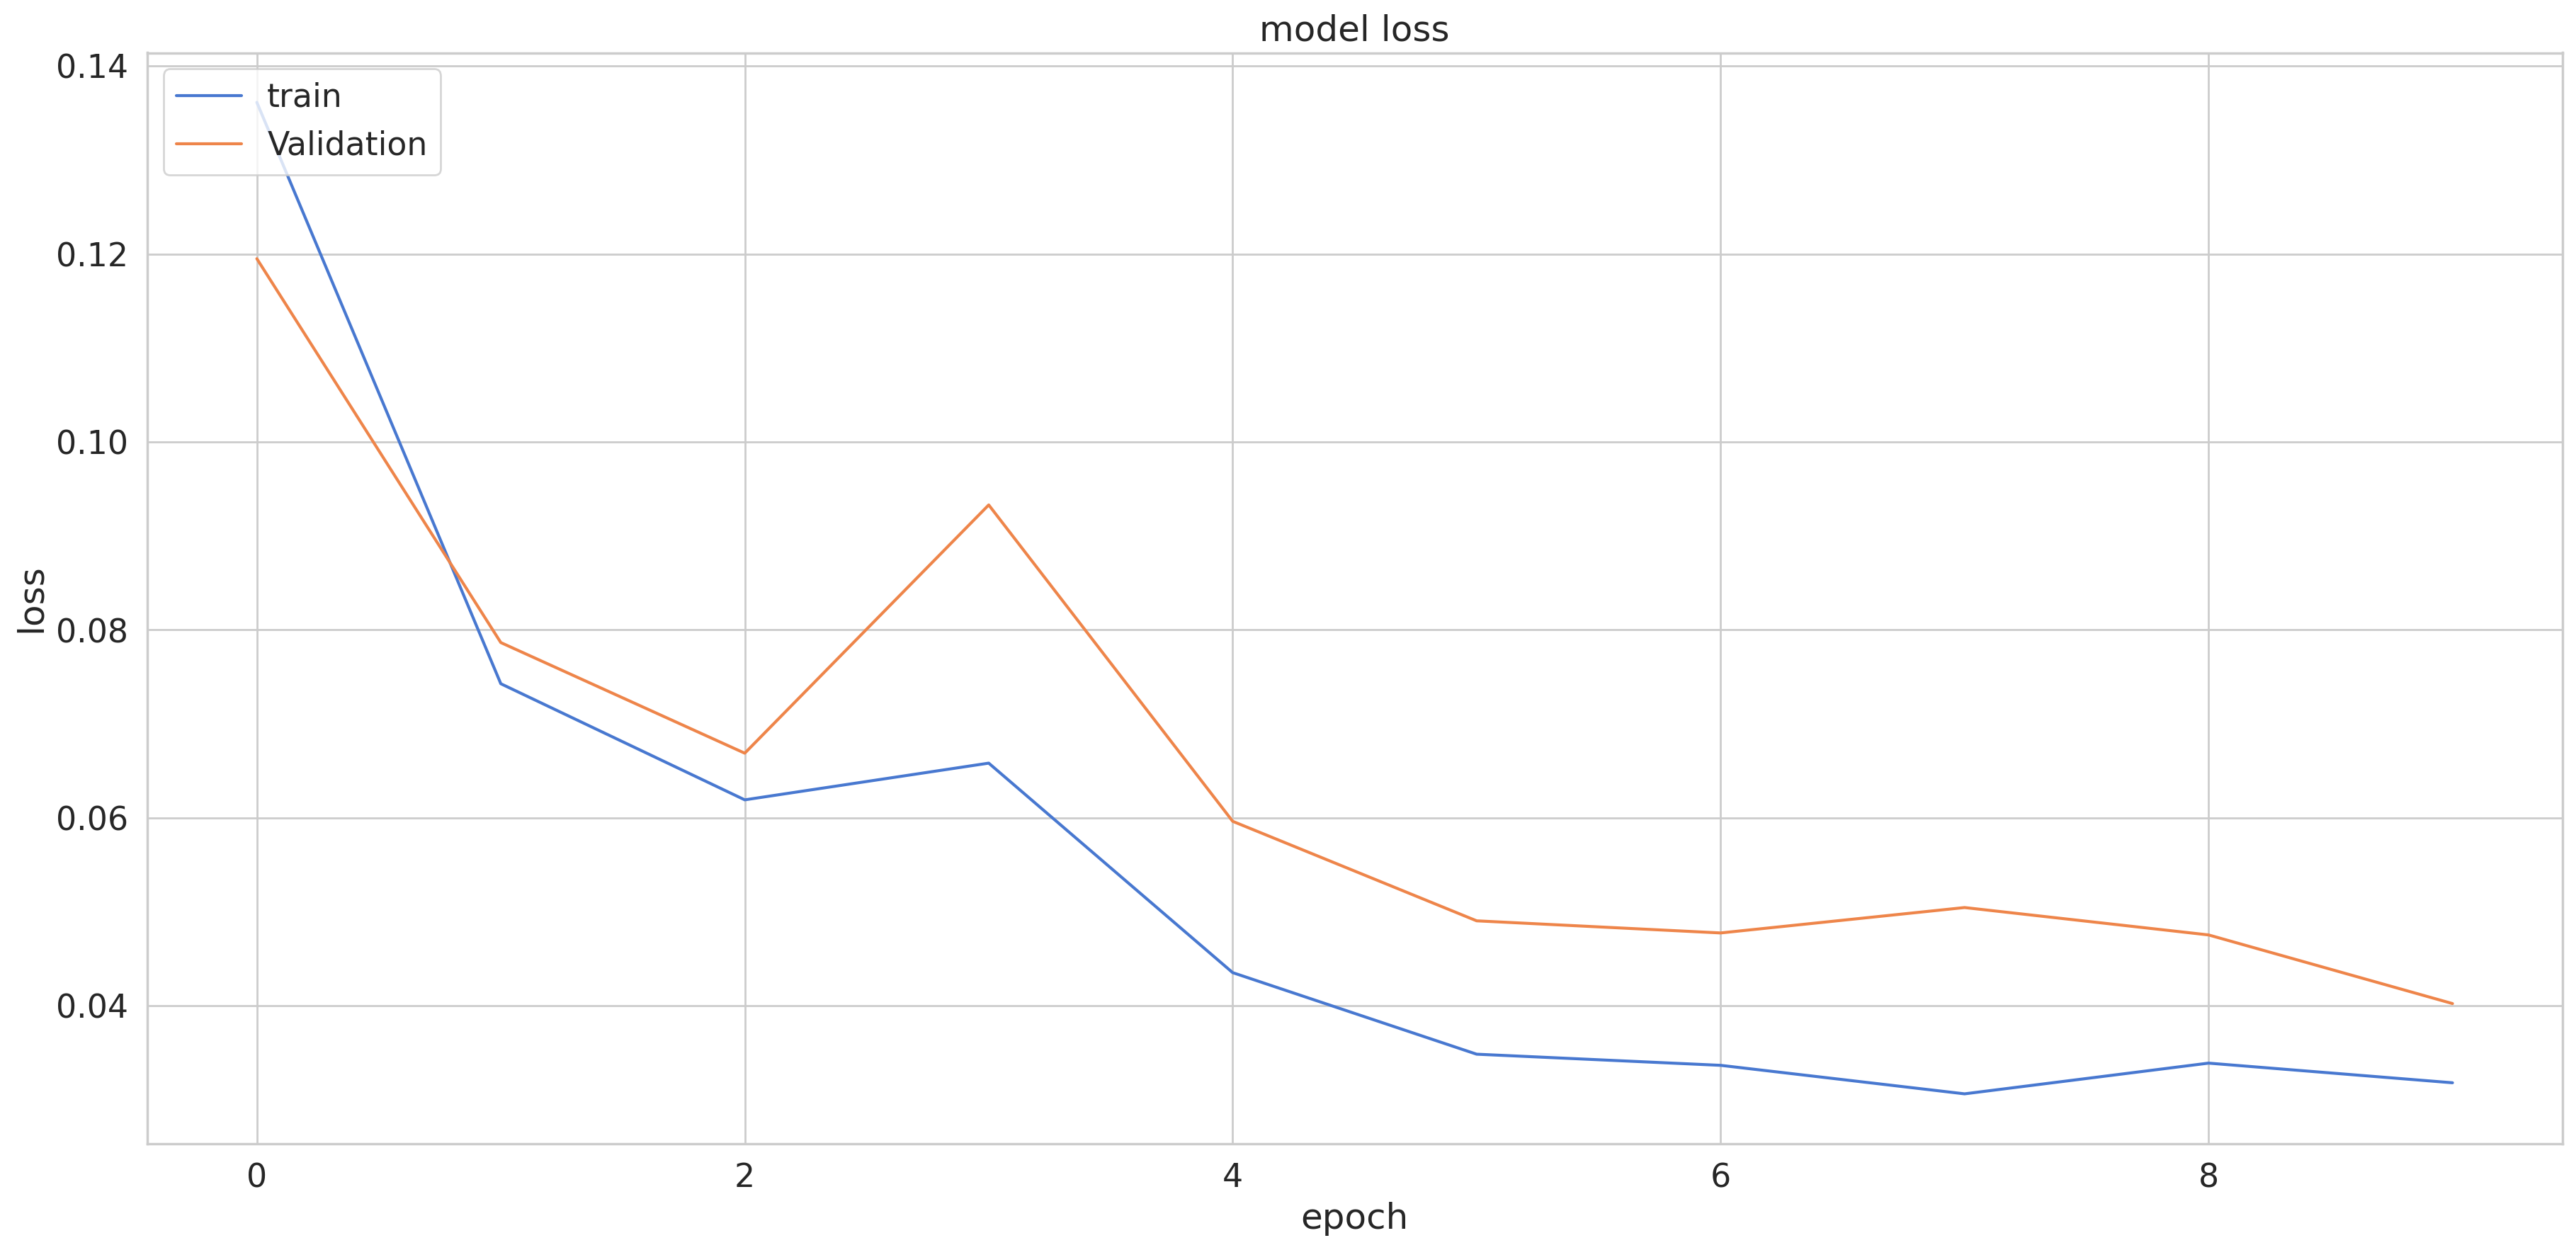

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

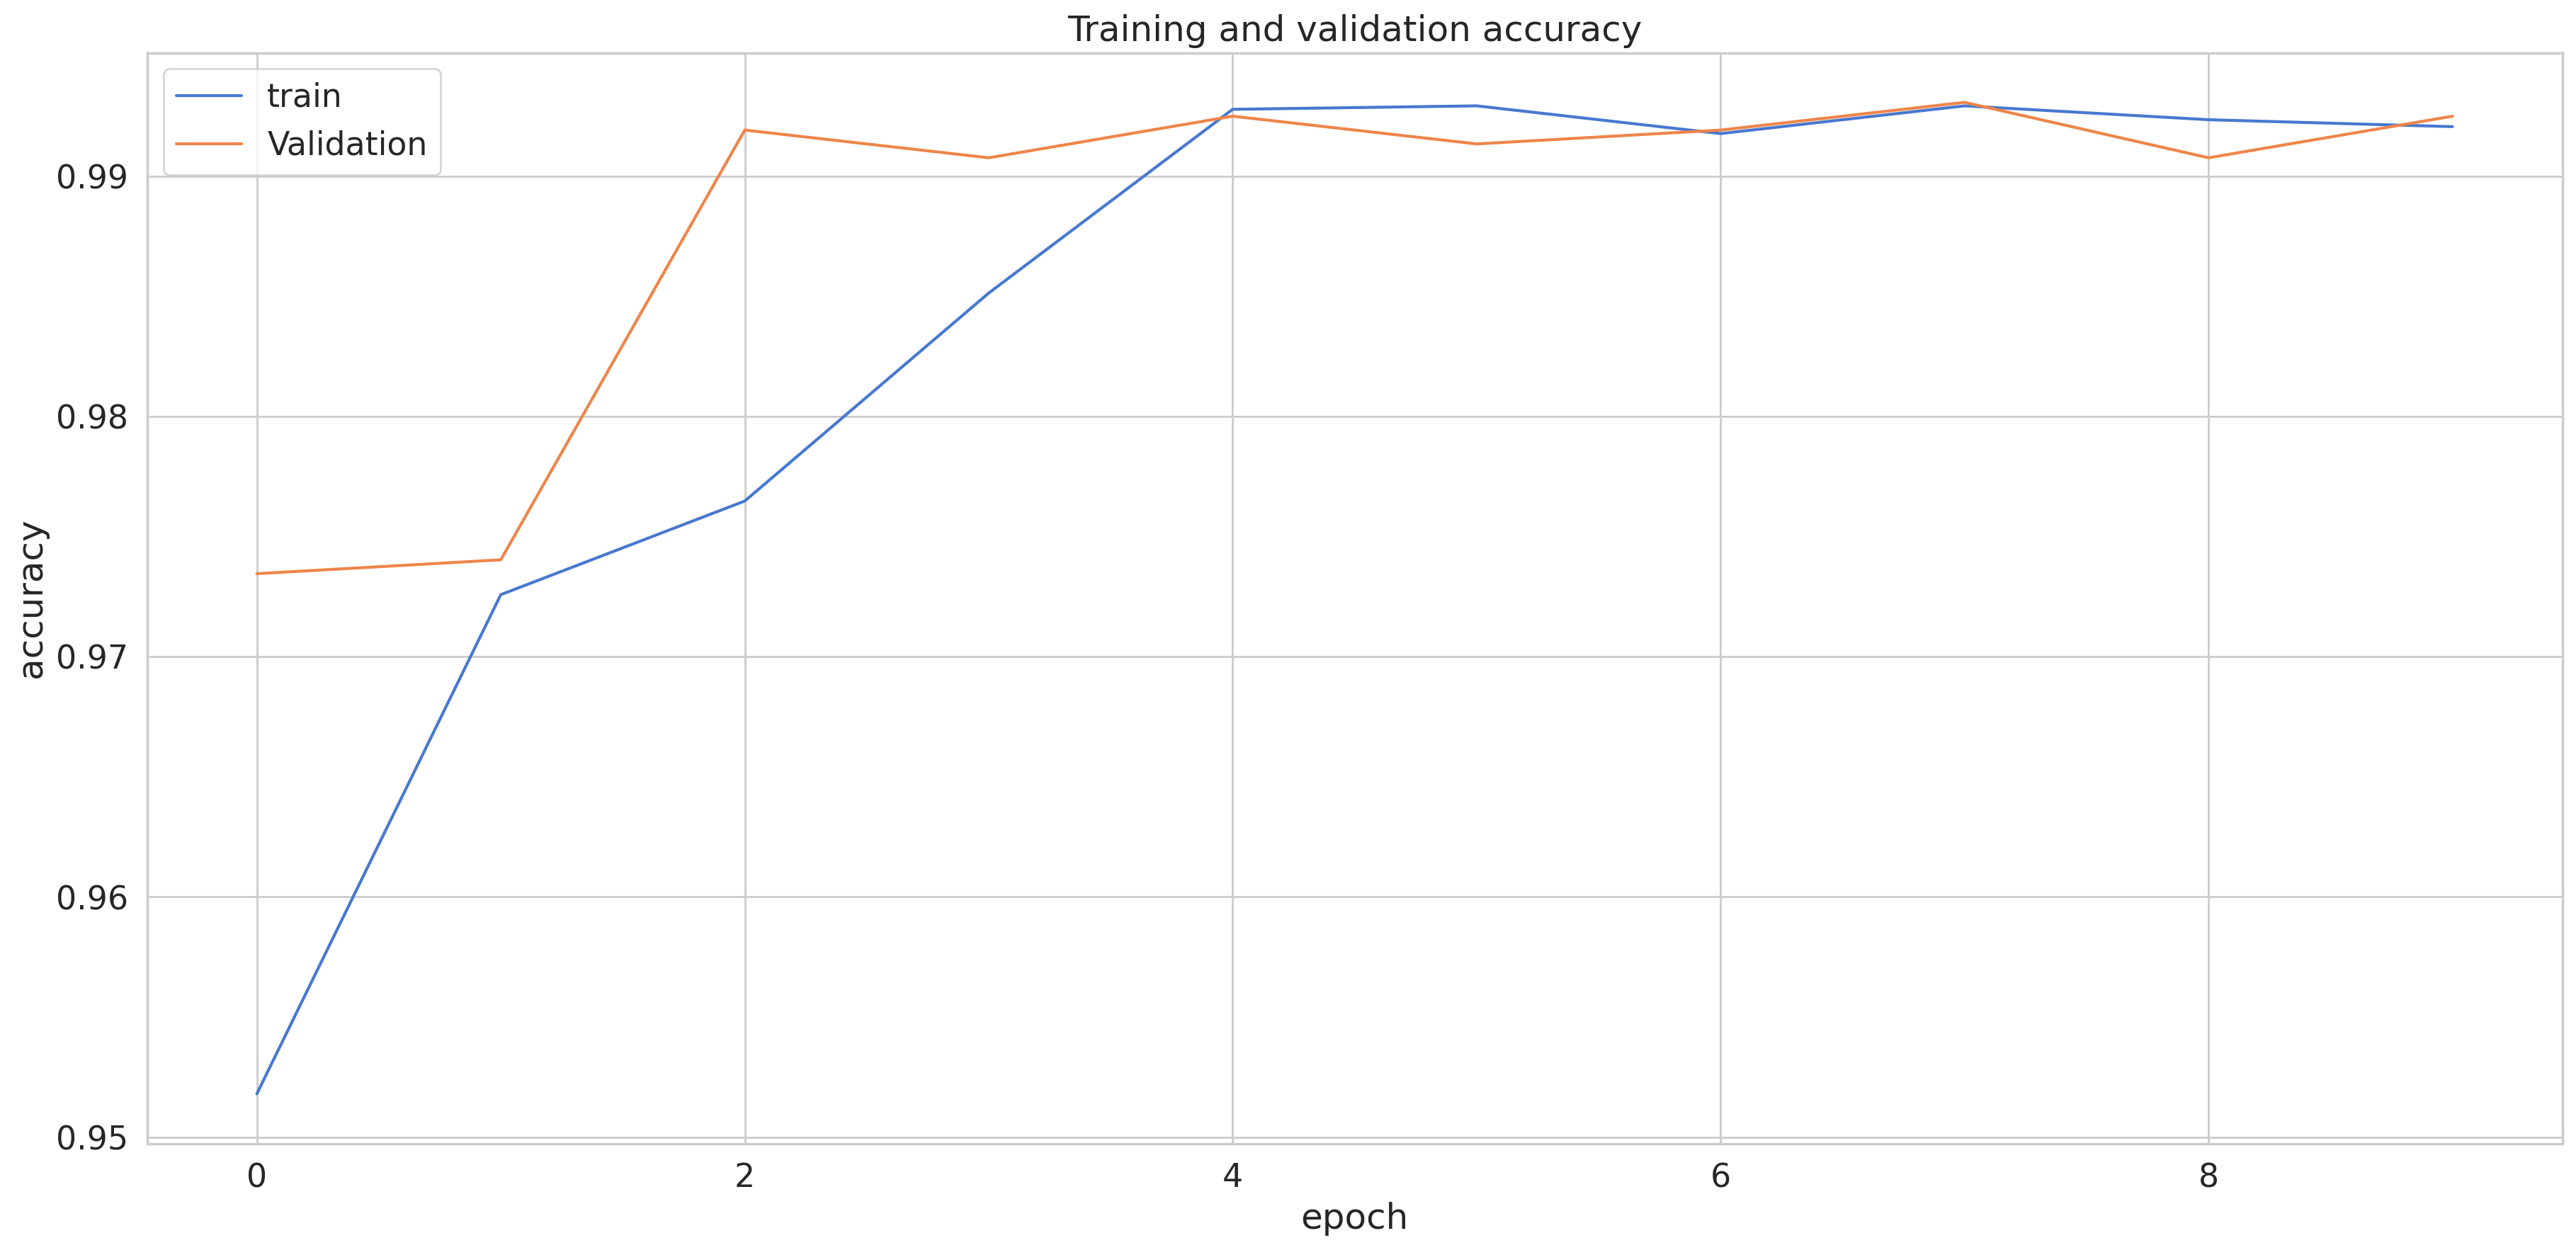

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 1s 4ms/step
f1_score =  0.9958466719093766
0.9958448753462604
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1199
           1       0.99      1.00      1.00       967

    accuracy                           1.00      2166
   macro avg       1.00      1.00      1.00      2166
weighted avg       1.00      1.00      1.00      2166



<Axes: >

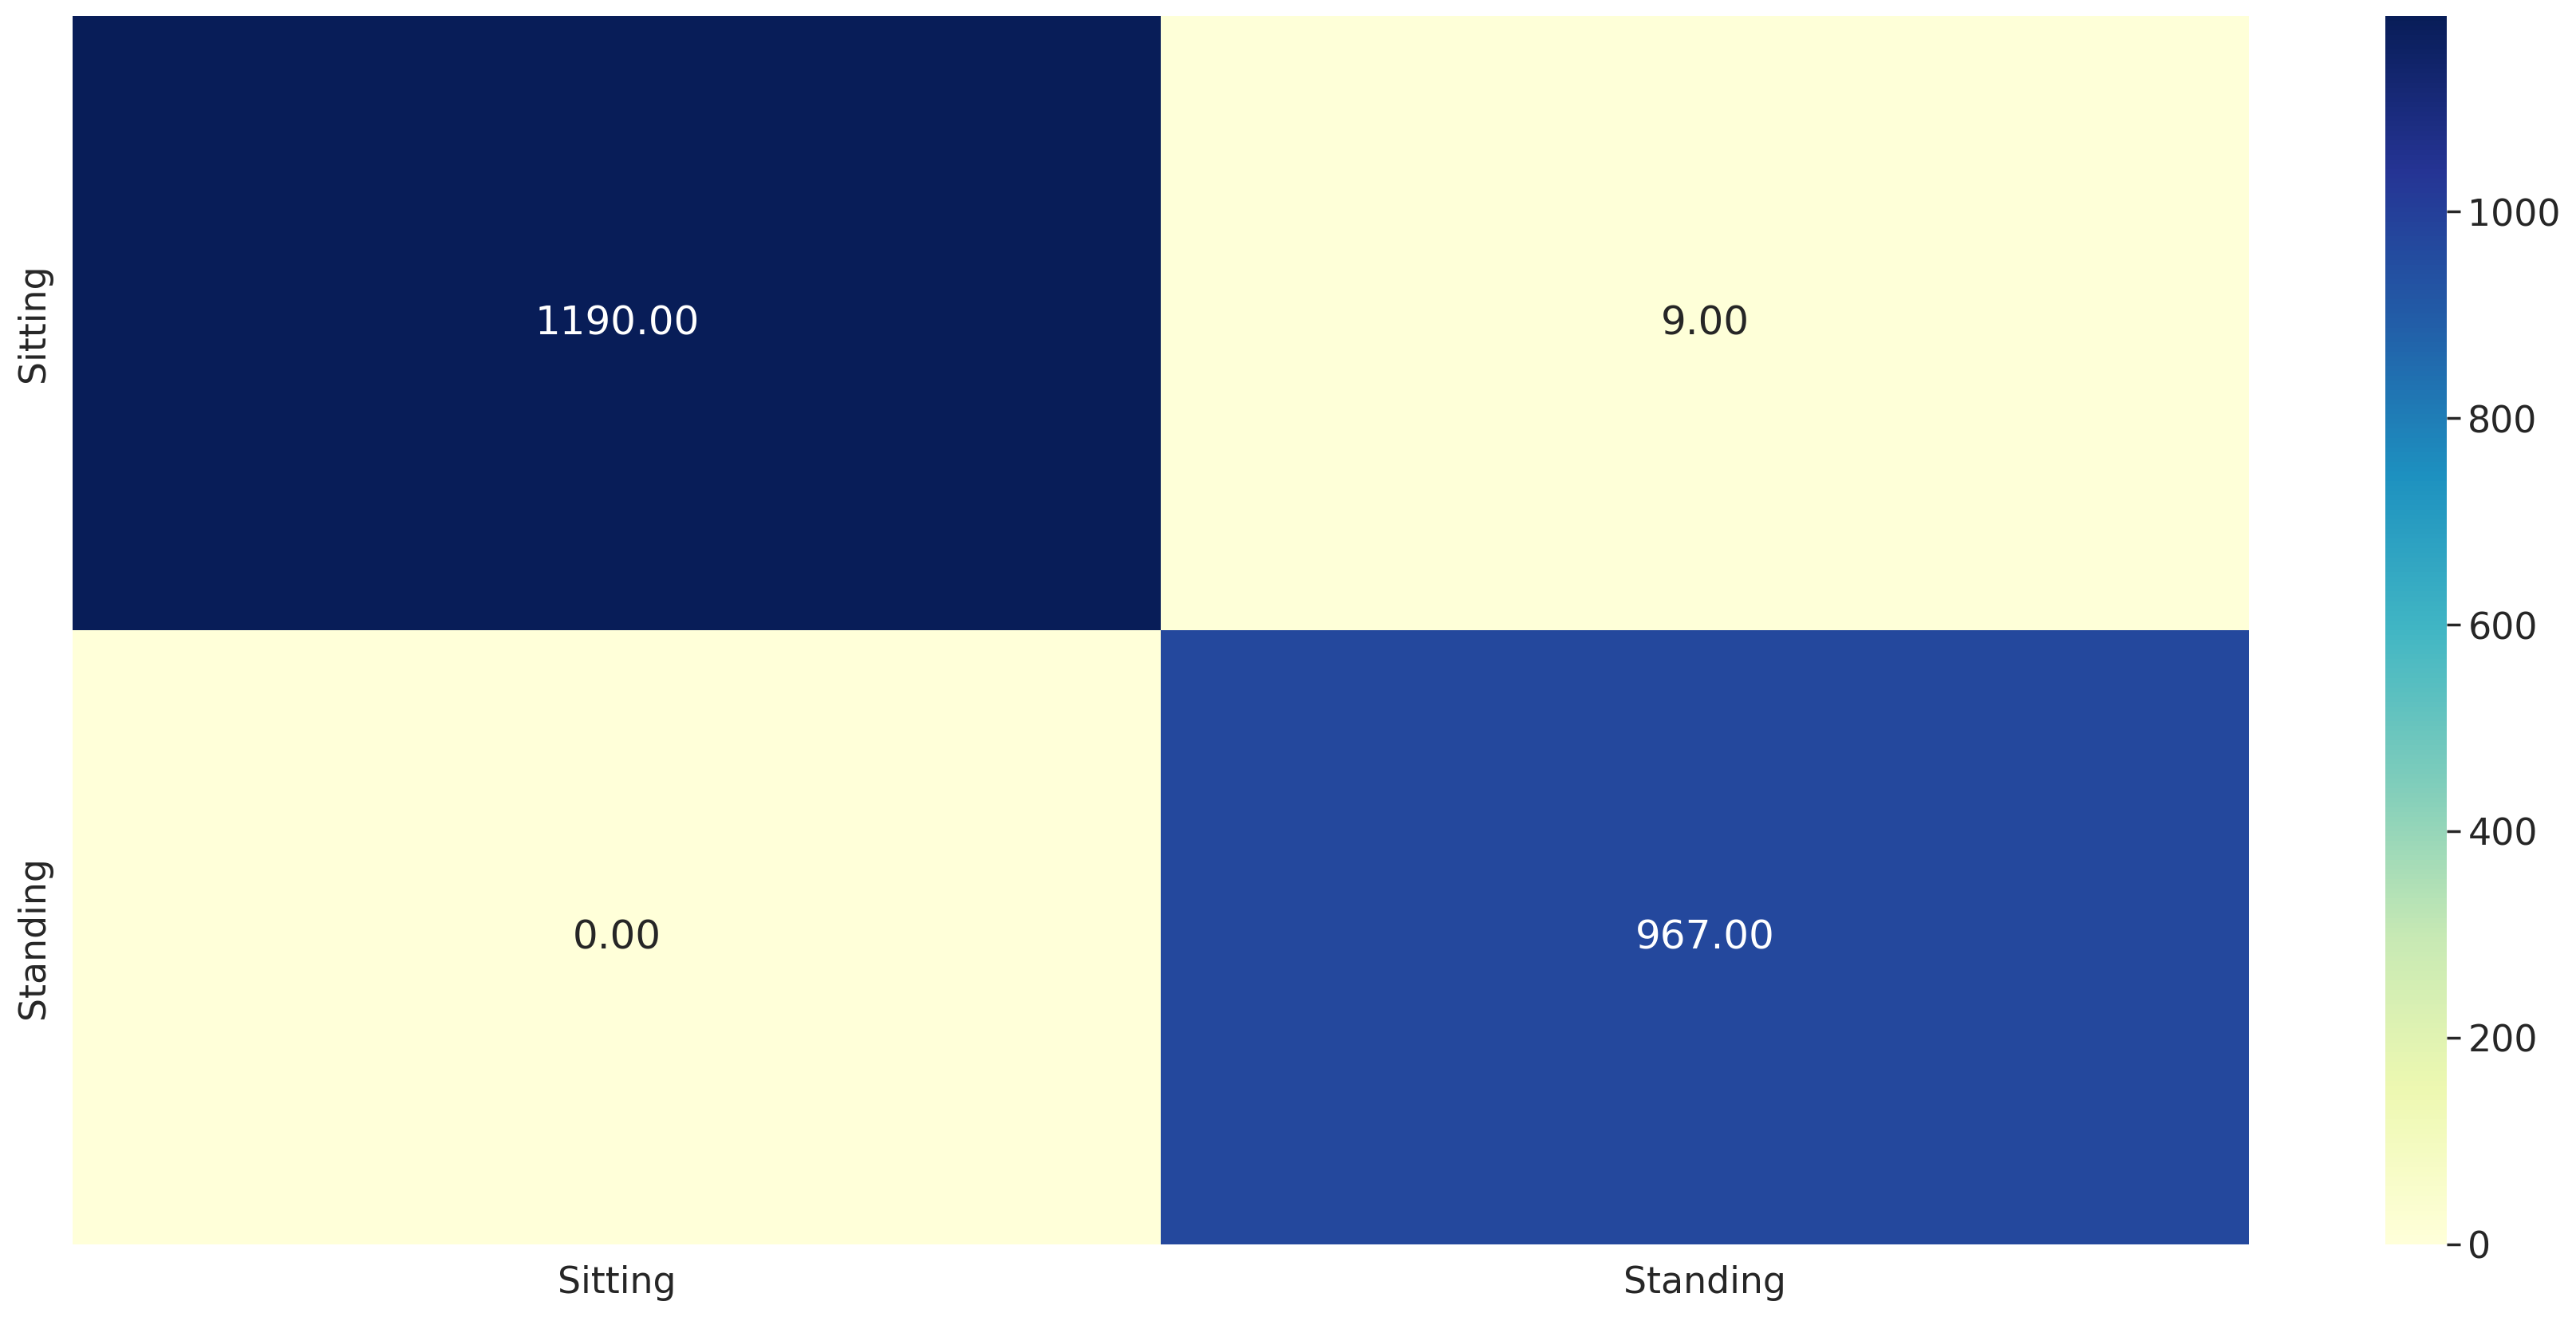

In [24]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM2 - CNN1

In [25]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
# RNN layer
model.add(LSTM(units = 128, return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 128)           67584     
                                                                 
 dropout_4 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_5 (Dropout)         (None, 50, 128)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 48, 64)            24640     
                                                                 
 dropout_6 (Dropout)         (None, 48, 64)            0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 24, 64)           

In [26]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 6s 27ms/step - loss: 0.1359 - accuracy: 0.9494 - val_loss: 0.0764 - val_accuracy: 0.9723
Epoch 2/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0909 - accuracy: 0.9681 - val_loss: 0.0934 - val_accuracy: 0.9723
Epoch 3/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0653 - accuracy: 0.9768 - val_loss: 0.0789 - val_accuracy: 0.9867
Epoch 4/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0649 - accuracy: 0.9848 - val_loss: 0.0705 - val_accuracy: 0.9740
Epoch 5/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0467 - accuracy: 0.9900 - val_loss: 0.0527 - val_accuracy: 0.9925
Epoch 6/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0343 - accuracy: 0.9922 - val_loss: 0.0488 - val_accuracy: 0.9925
Epoch 7/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0631 - accuracy: 0.9874 - val_loss: 0.0971 - val_accuracy: 0.9706
Epoch 8/10
55

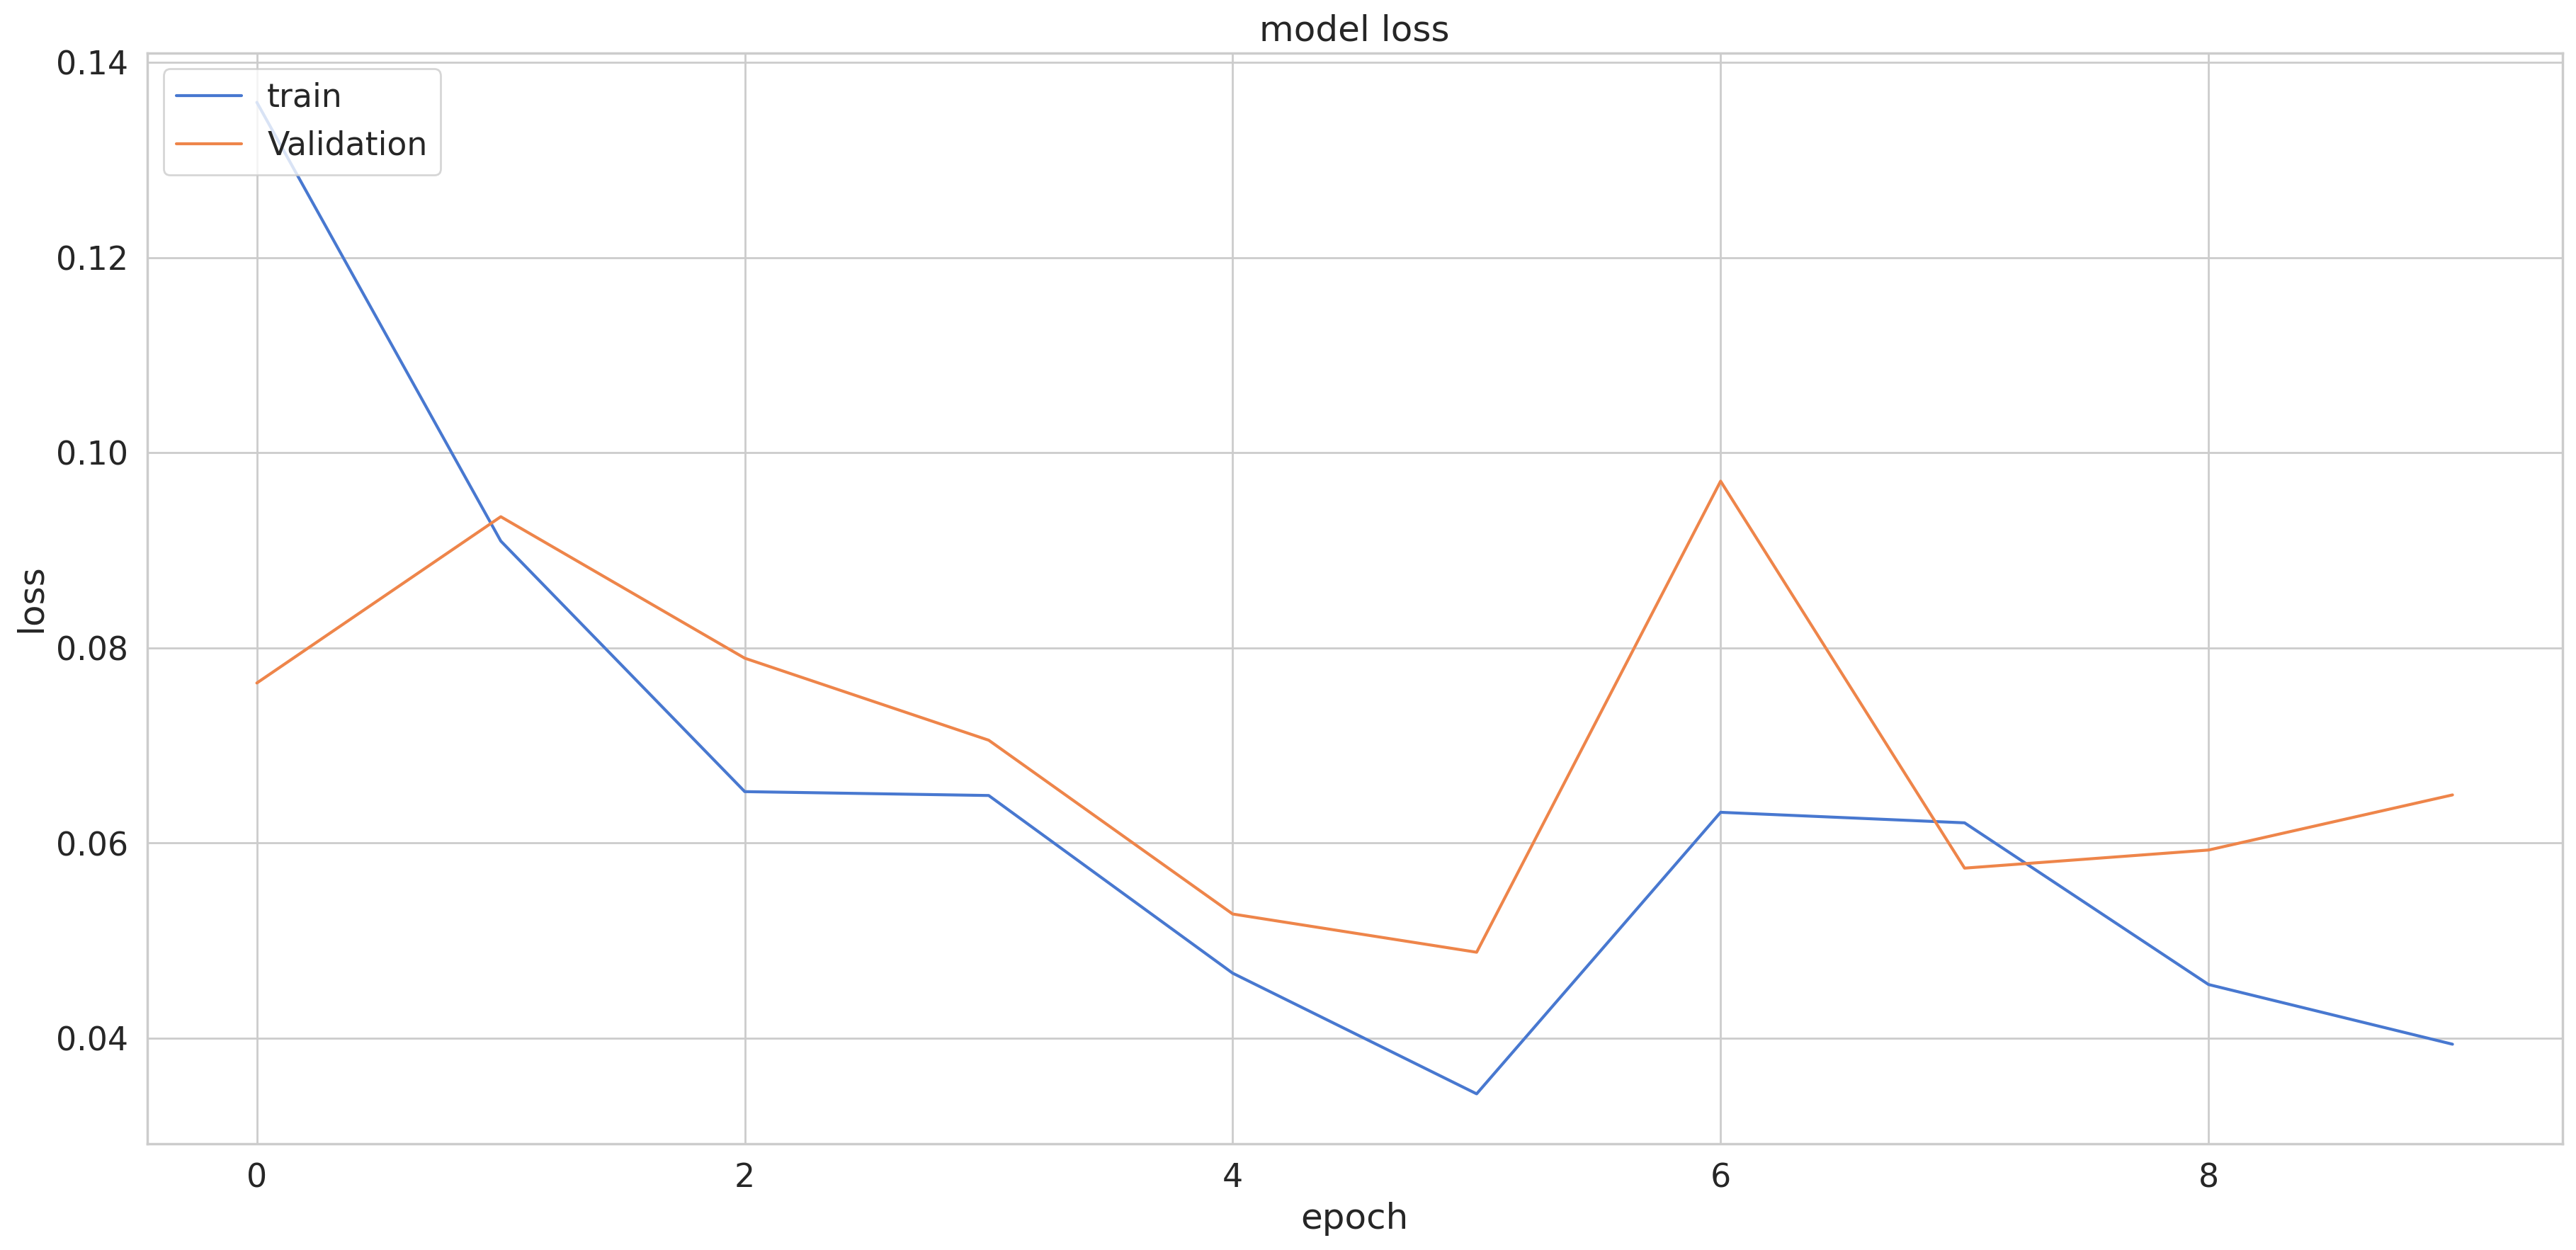

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

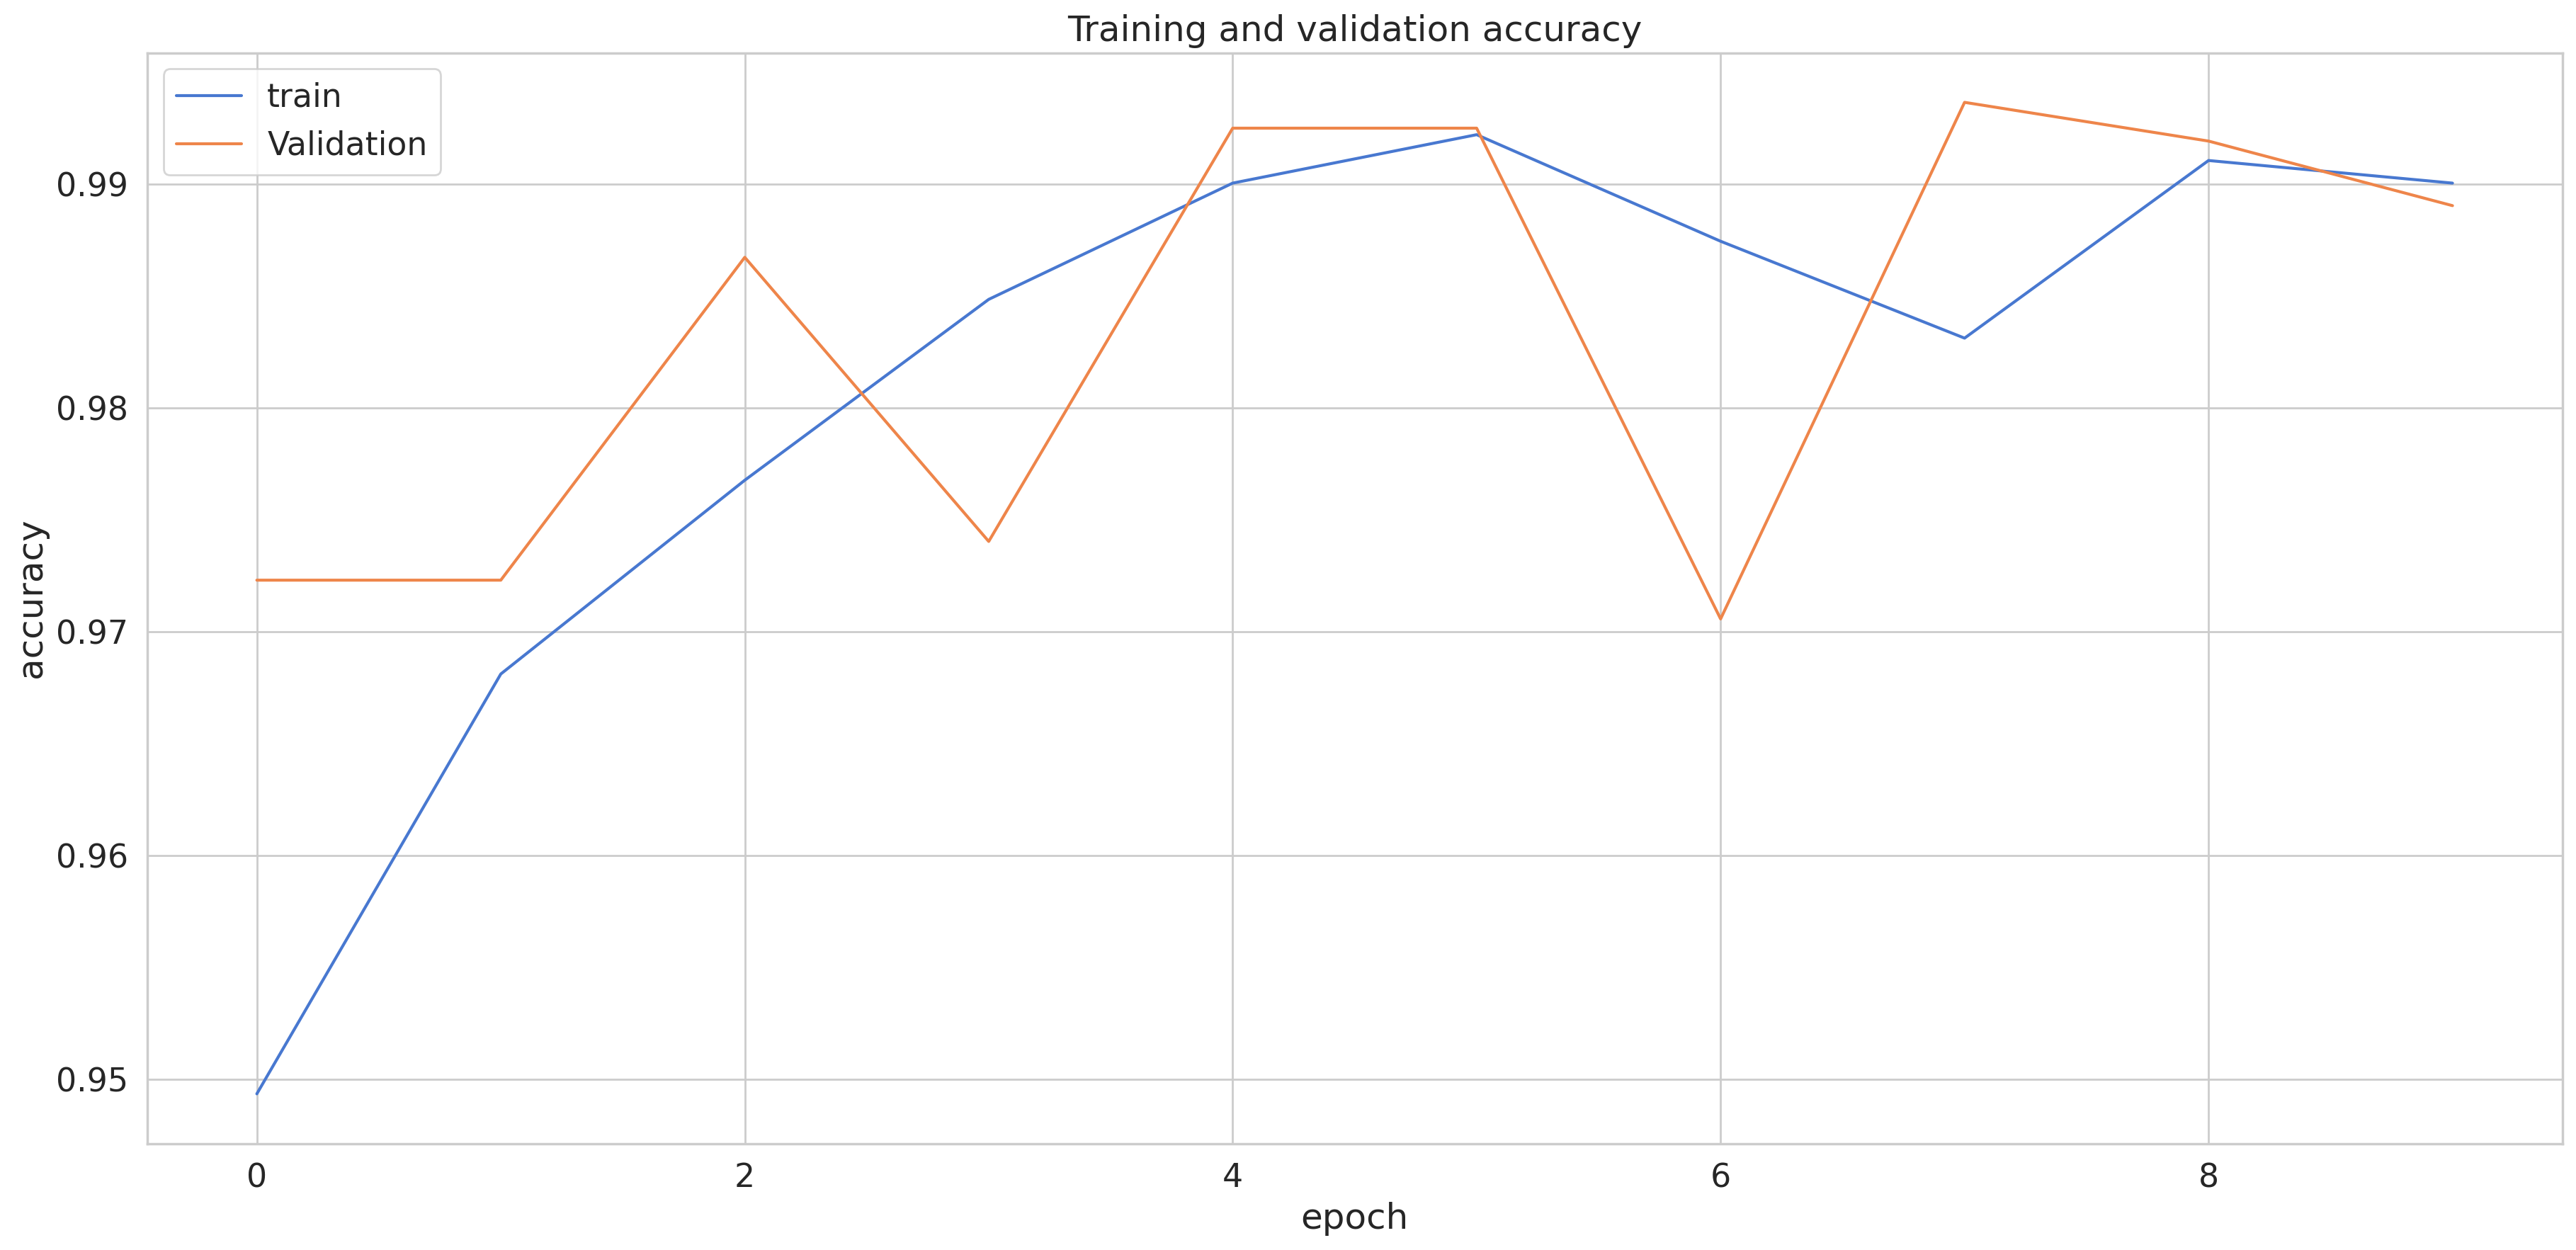

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 1s 5ms/step
f1_score =  0.9907748152613222
0.9907663896583564
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1199
           1       0.98      1.00      0.99       967

    accuracy                           0.99      2166
   macro avg       0.99      0.99      0.99      2166
weighted avg       0.99      0.99      0.99      2166



<Axes: >

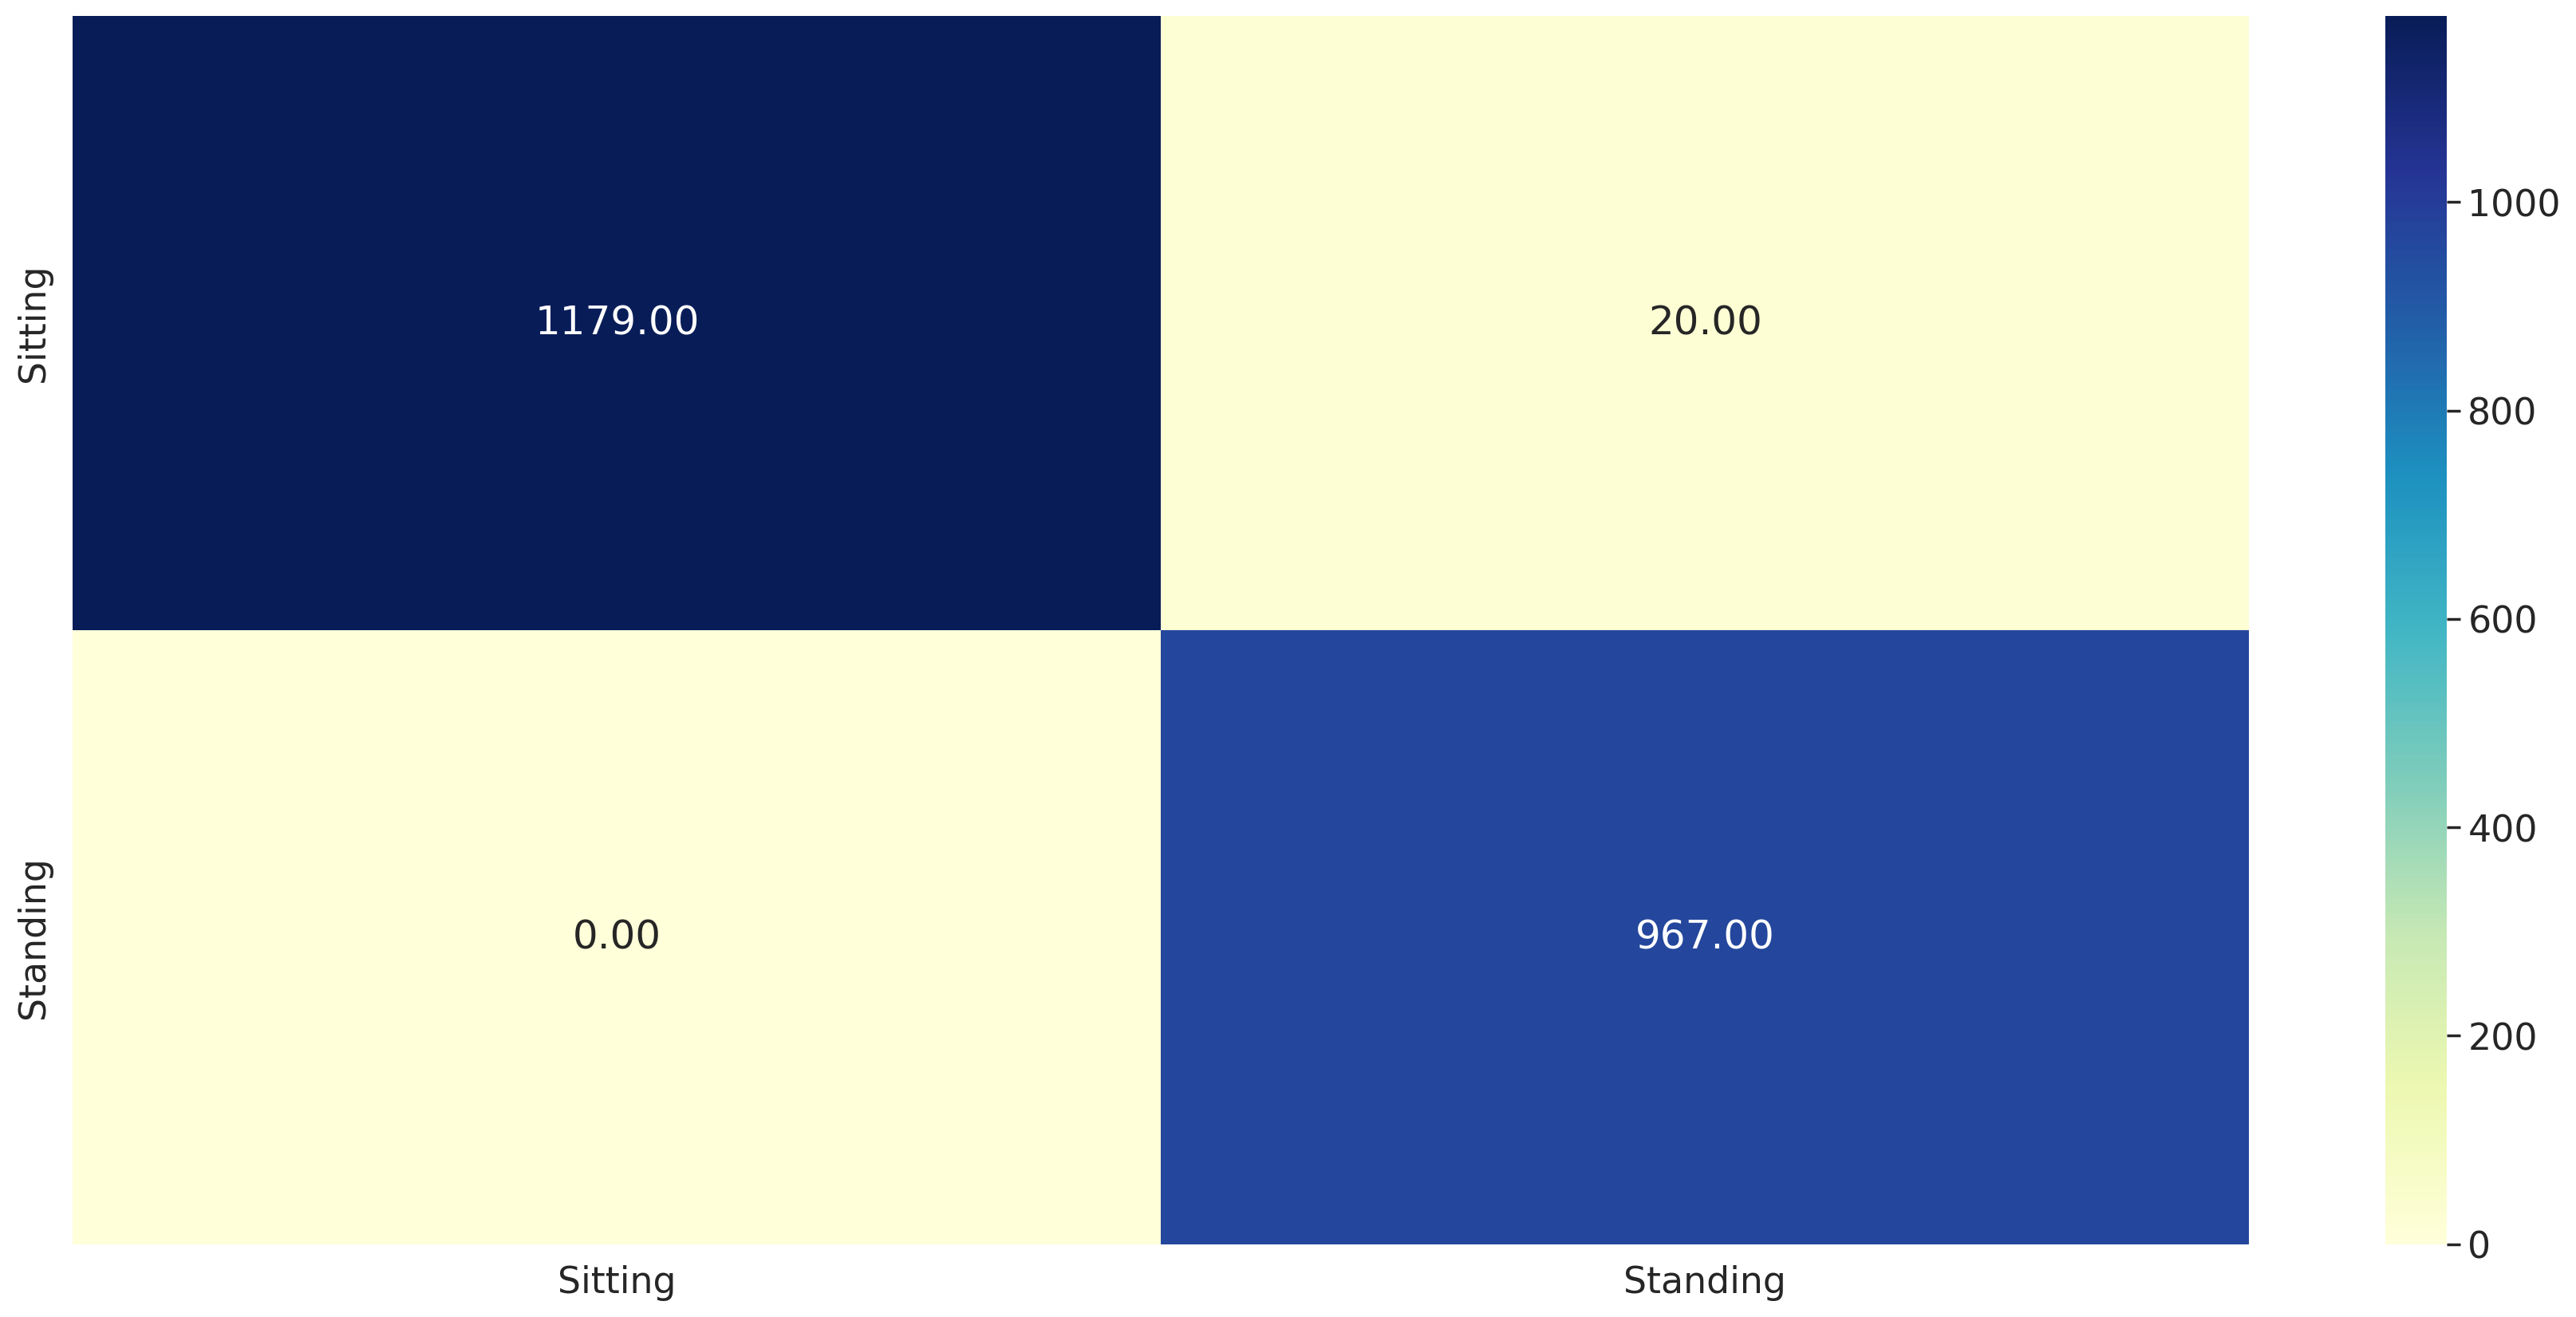

In [29]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# LSTM2 - CNN2

In [30]:
model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2]),  return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
# RNN layer
model.add(LSTM(units = 128, return_sequences=True))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())


model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(y_train_hot.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50, 128)           67584     
                                                                 
 dropout_7 (Dropout)         (None, 50, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_8 (Dropout)         (None, 50, 128)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 48, 64)            24640     
                                                                 
 conv1d_5 (Conv1D)           (None, 46, 64)            12352     
                                                                 
 dropout_9 (Dropout)         (None, 46, 64)           

In [31]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
55/55 [==============================] - 6s 27ms/step - loss: 0.1493 - accuracy: 0.9492 - val_loss: 0.1045 - val_accuracy: 0.9717
Epoch 2/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0877 - accuracy: 0.9706 - val_loss: 0.0990 - val_accuracy: 0.9706
Epoch 3/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0776 - accuracy: 0.9714 - val_loss: 0.0710 - val_accuracy: 0.9717
Epoch 4/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0514 - accuracy: 0.9838 - val_loss: 0.0827 - val_accuracy: 0.9740
Epoch 5/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0602 - accuracy: 0.9870 - val_loss: 0.0387 - val_accuracy: 0.9931
Epoch 6/10
55/55 [==============================] - 1s 12ms/step - loss: 0.0467 - accuracy: 0.9893 - val_loss: 0.0386 - val_accuracy: 0.9931
Epoch 7/10
55/55 [==============================] - 1s 15ms/step - loss: 0.0400 - accuracy: 0.9928 - val_loss: 0.0478 - val_accuracy: 0.9925
Epoch 8/10
55

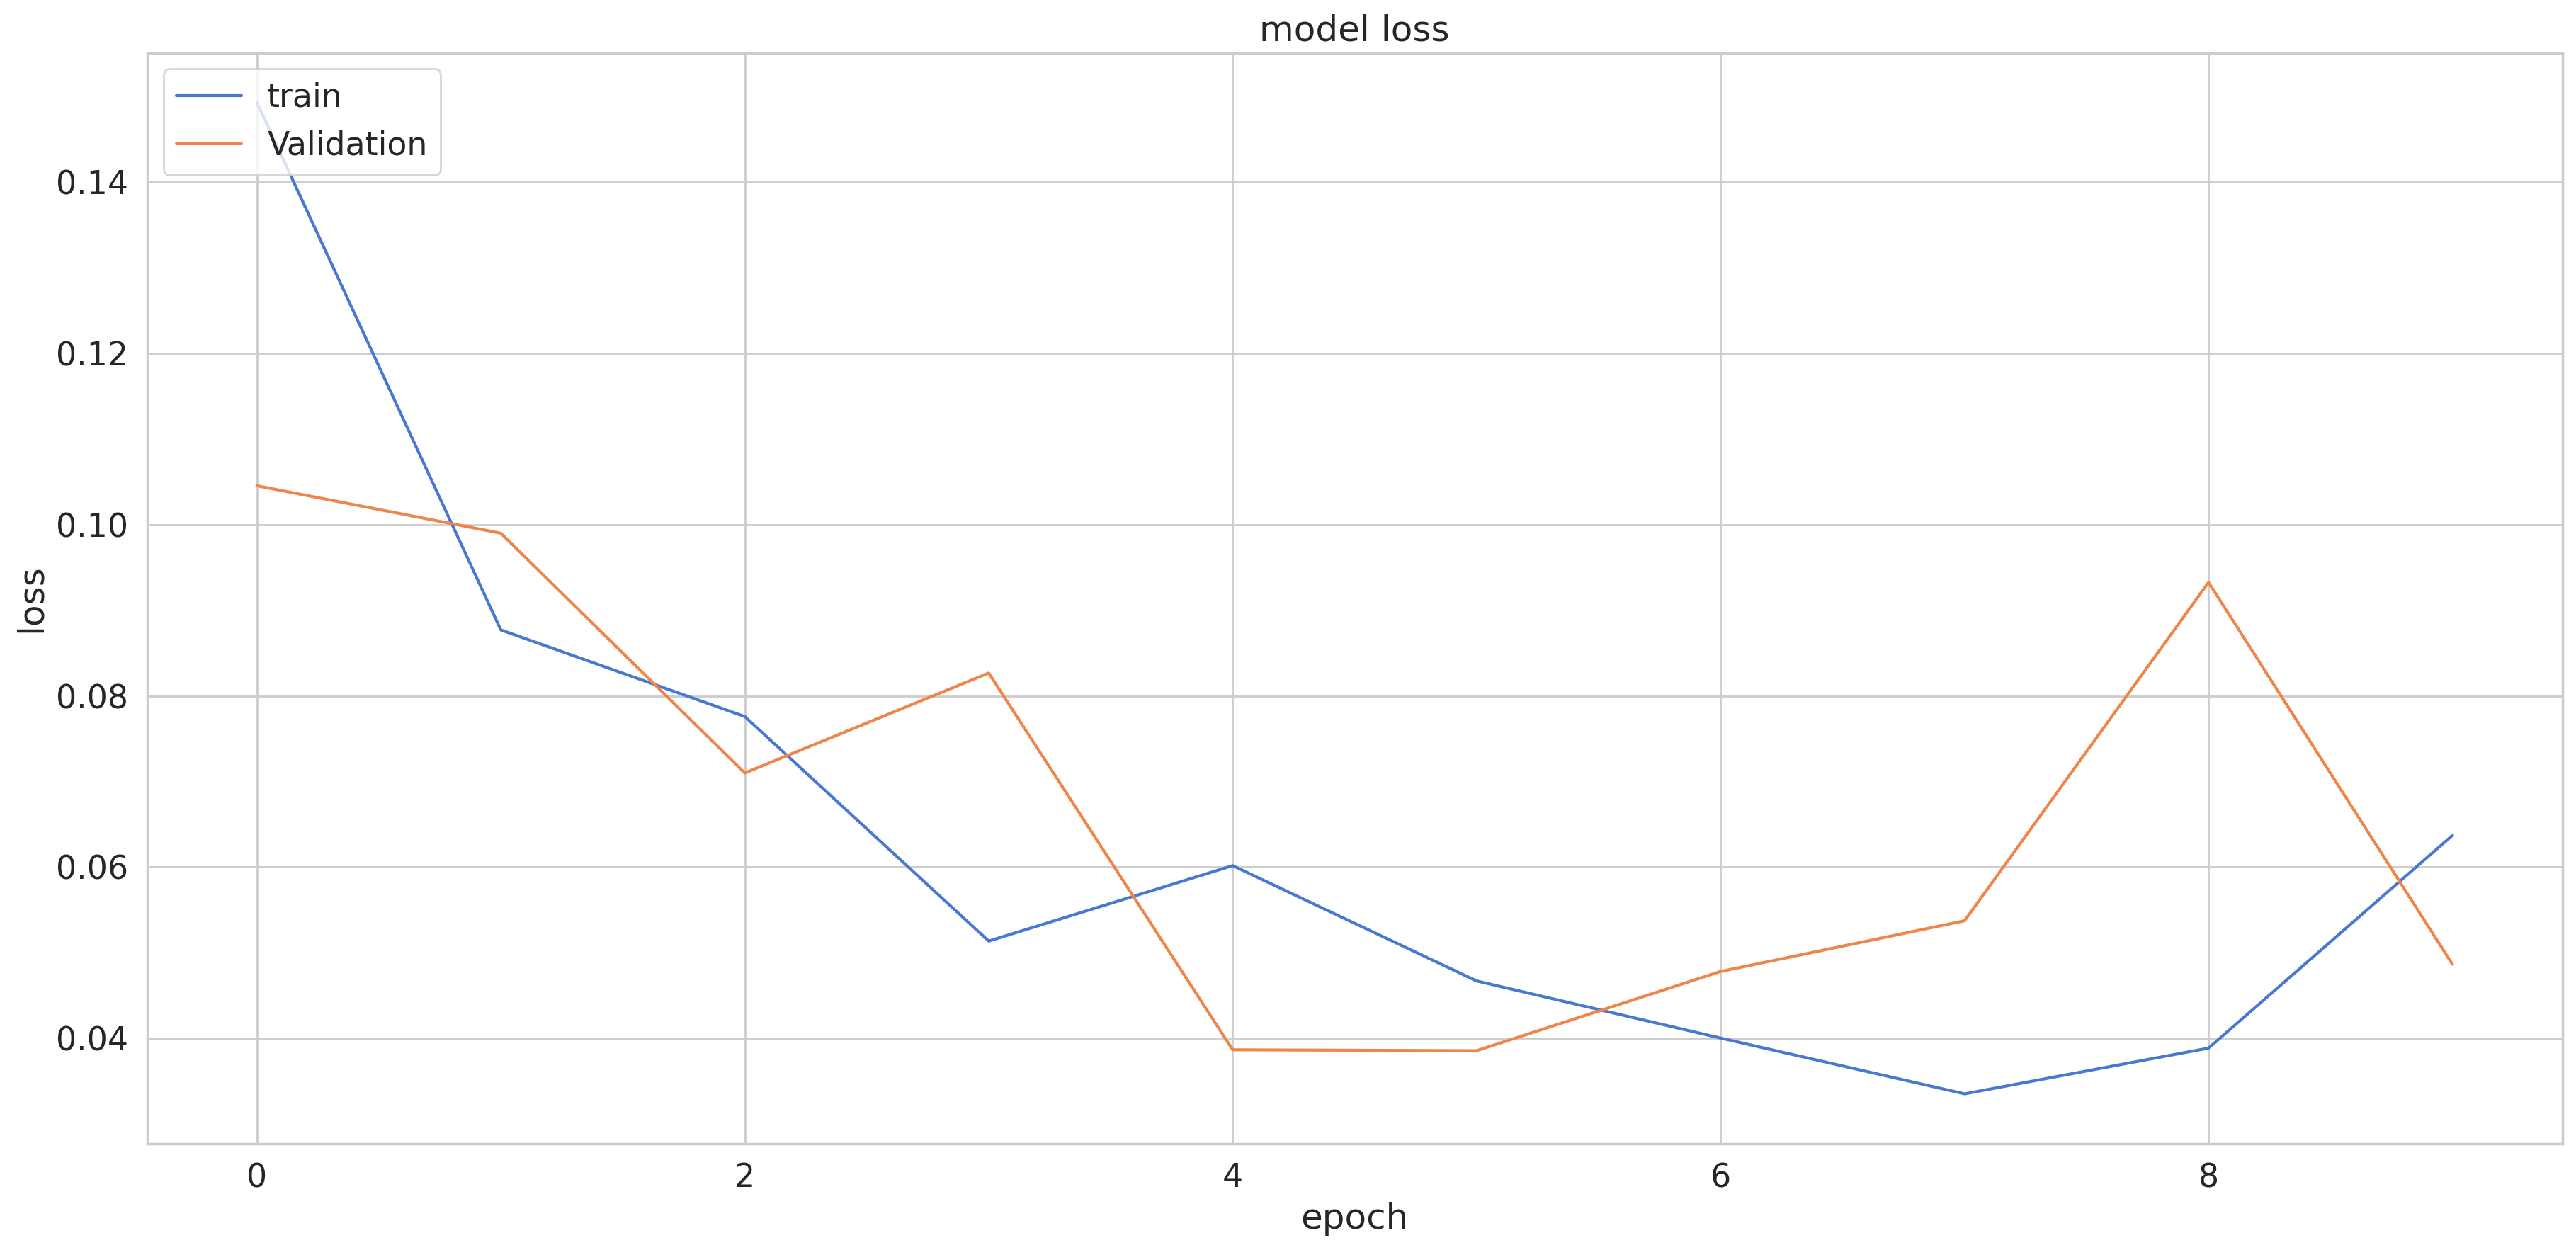

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

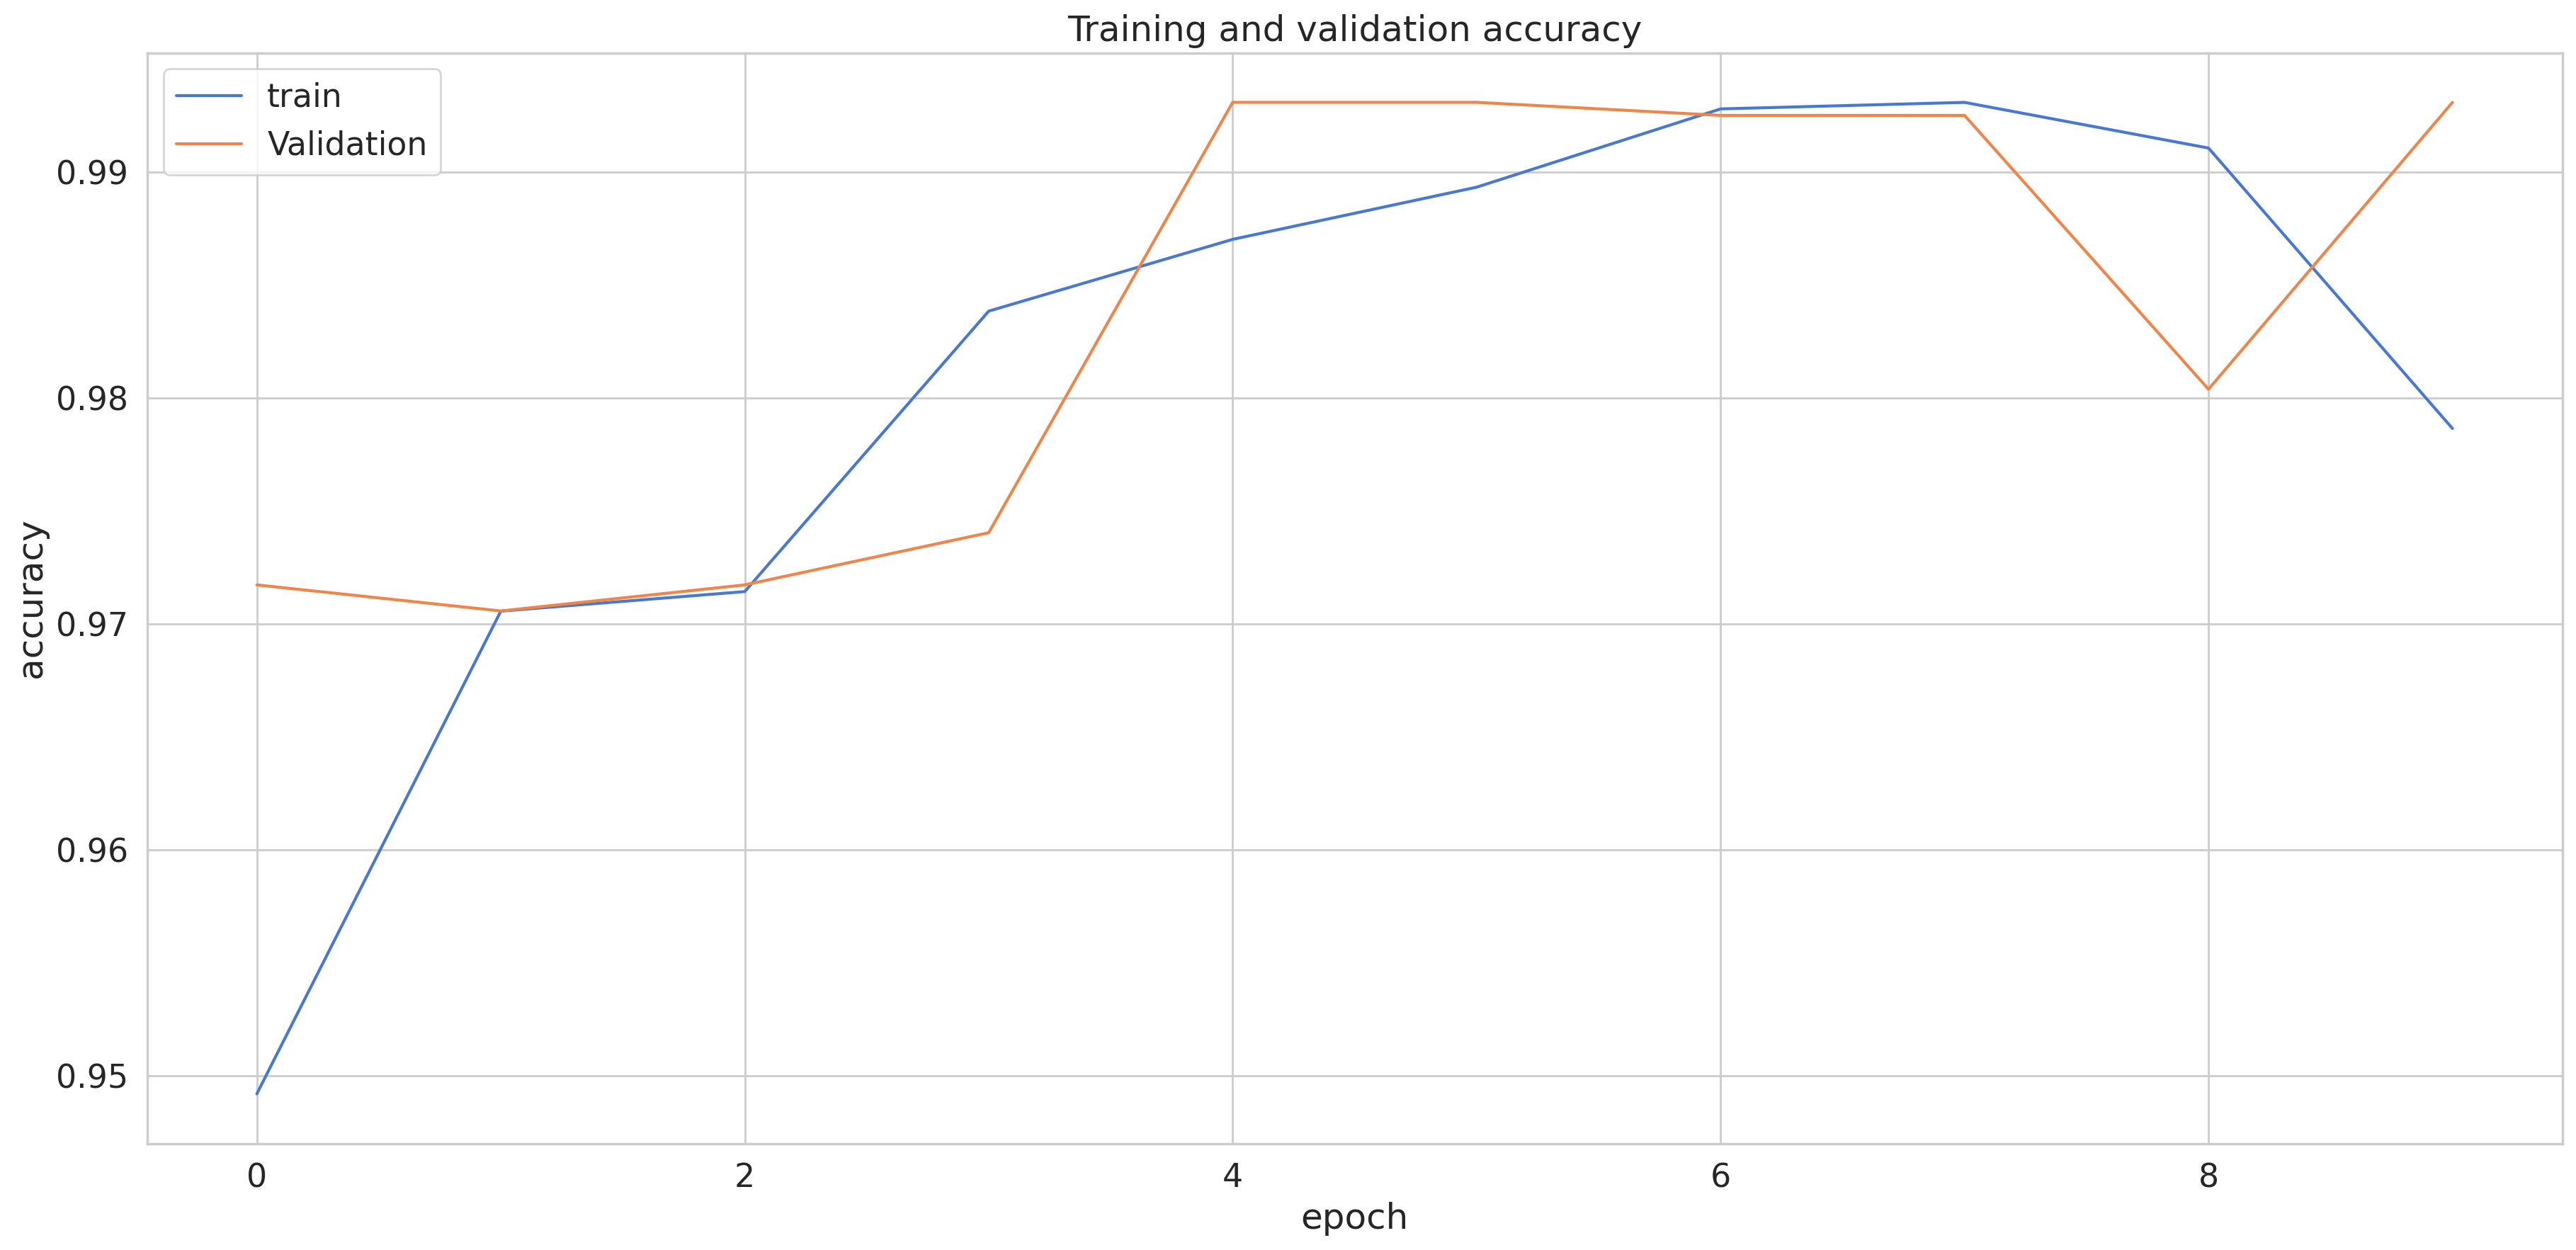

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

68/68 [==============================] - 1s 4ms/step
f1_score =  0.9953854026505811
0.9953831948291783
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1199
           1       0.99      1.00      0.99       967

    accuracy                           1.00      2166
   macro avg       0.99      1.00      1.00      2166
weighted avg       1.00      1.00      1.00      2166



<Axes: >

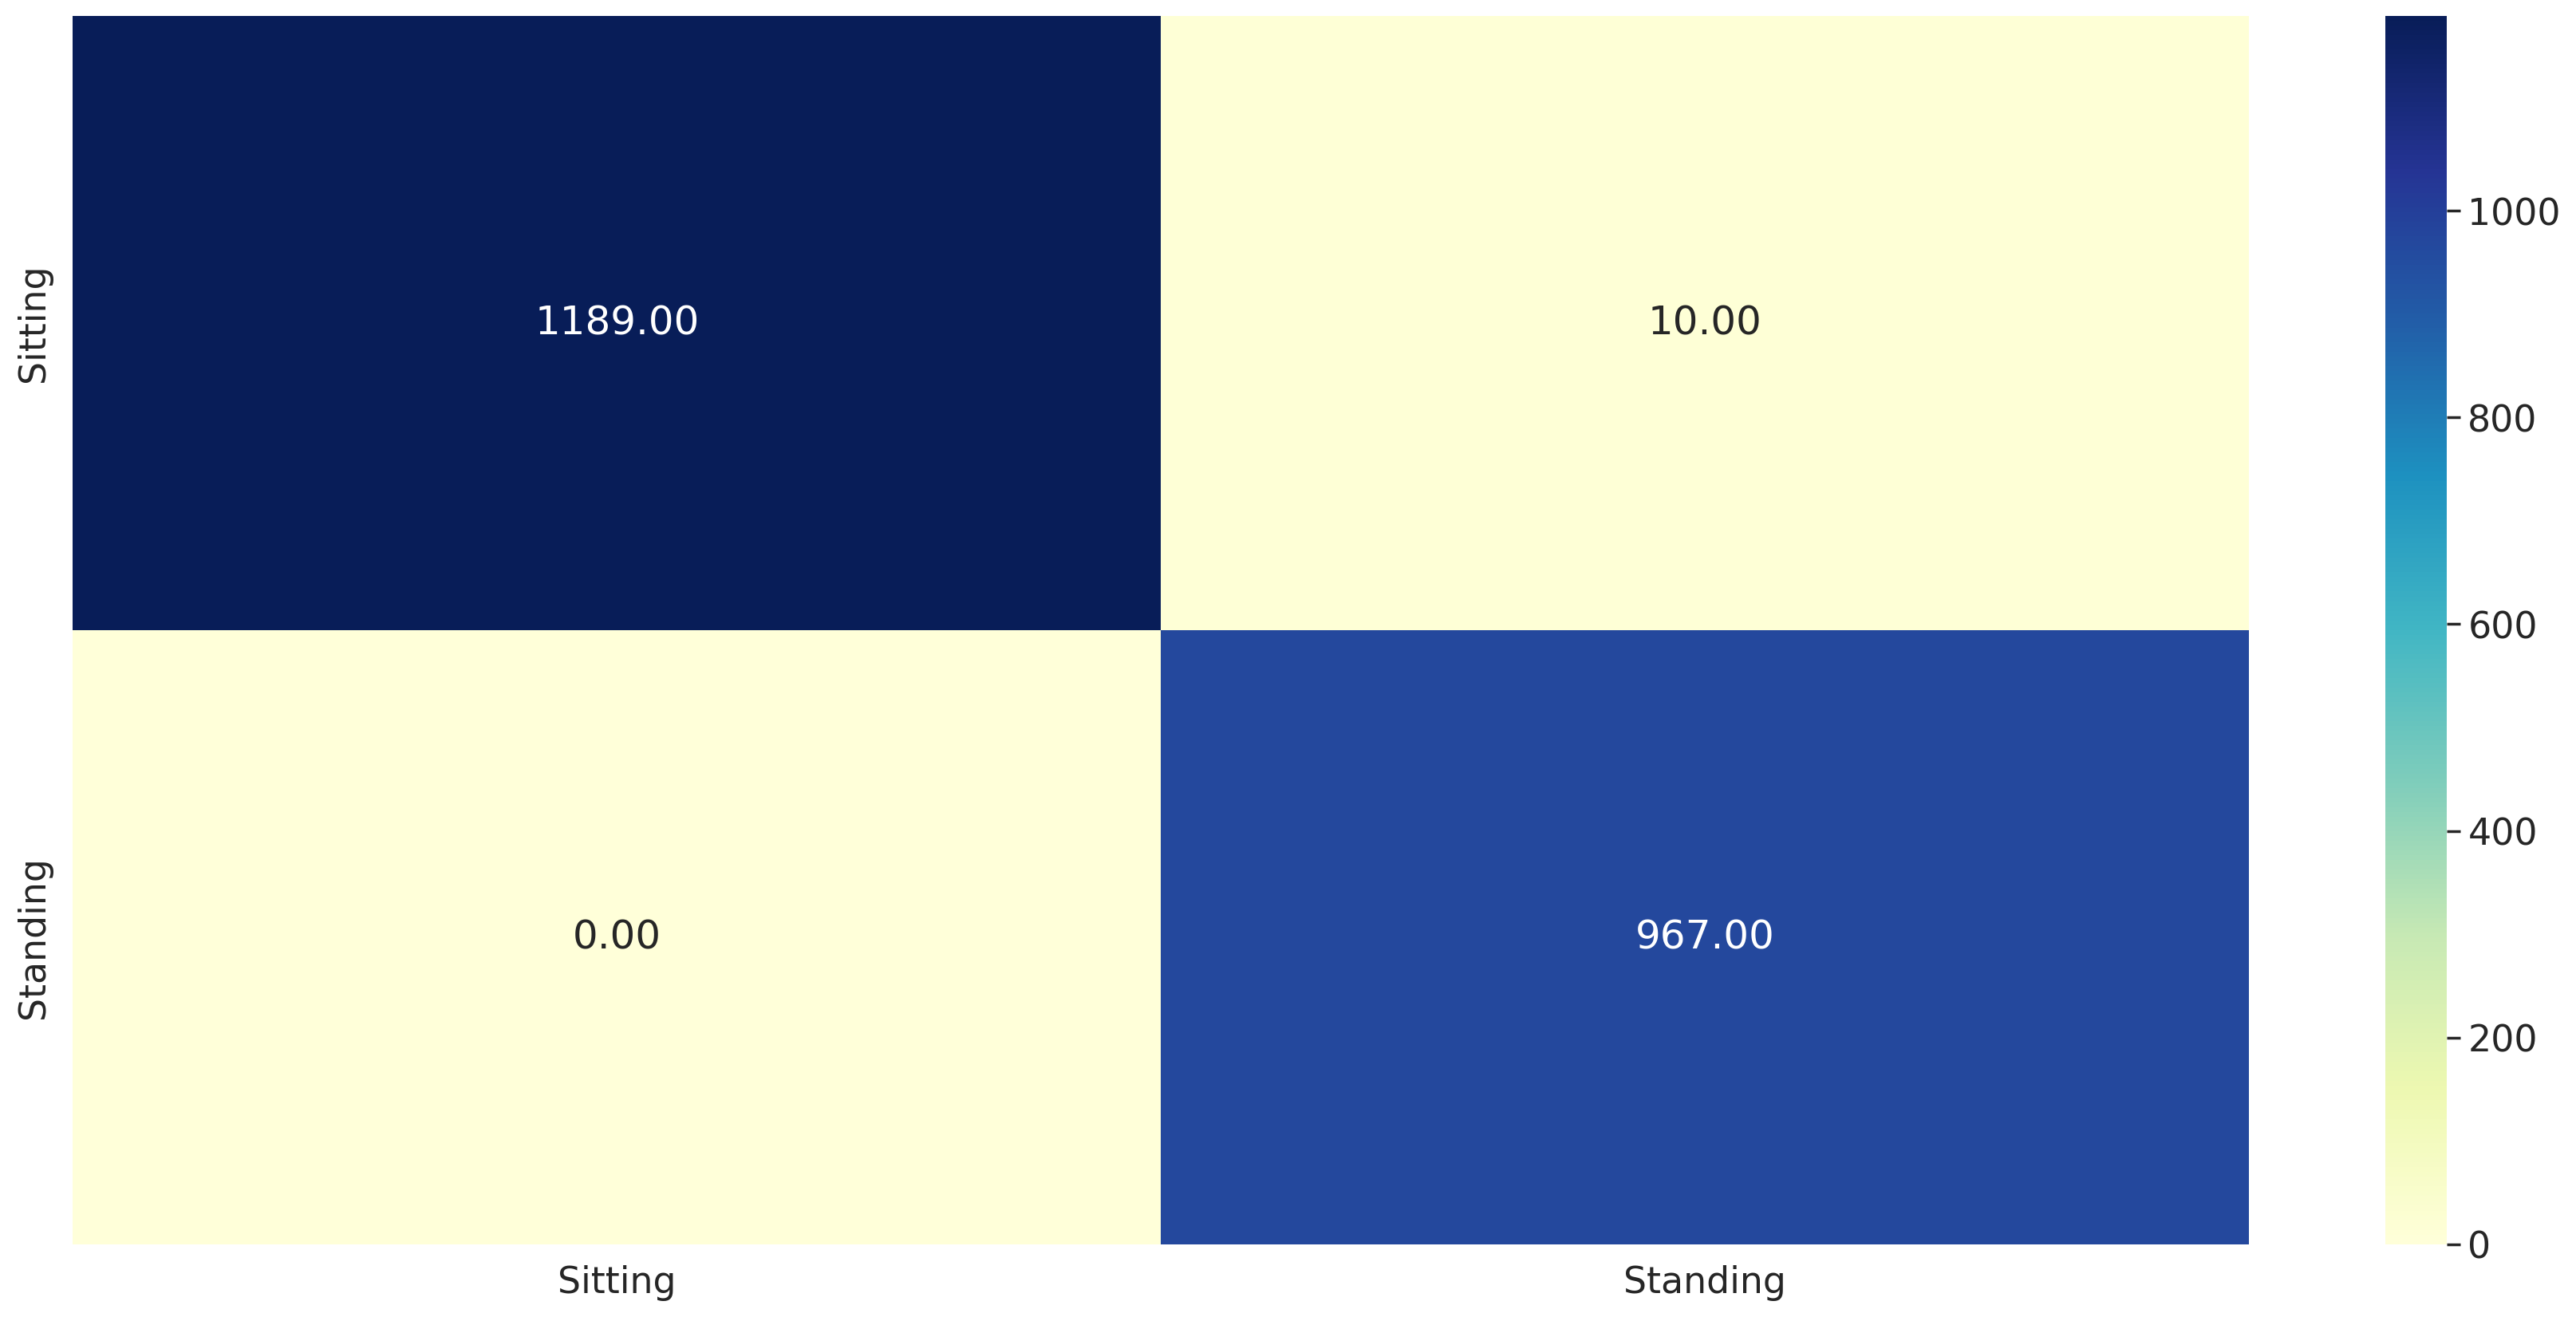

In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = [ 'Sitting', 'Standing']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_true, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')